In [1]:
import numpy as np
import CoolProp.CoolProp as CP
from cycle_functions import *
from scipy.optimize import minimize, Bounds, NonlinearConstraint, LinearConstraint
import warnings
import pandas as pd

def make_cycle(Vars, Inputs, Param):

    # ----------------------------------------------#
    # ==------ Vars  -------==#
    P_c    = Vars[0] # Pa
    P_e    = Vars[1] # Pa
    T_SH   = Vars[2] # delta-T K
    # ----------------------------------------------#
    #==------ Inputs ------==#
    
    T_amb  = Inputs[0] # K
    T_pod  = Inputs[1] # K
    Q_load = Inputs[2] # W
    
    #----------------------------------------------#
    #==------ Param -------==#
    RPM    = Param[0]
    RPM_cond = Param[1]
    RPM_evap = Param[2]
    
    #----------------------------------------------#
    #==-- Init. Outputs  --==#
    P = np.zeros(9) # Pa
    T = np.zeros(9) # K
    h = np.zeros(9) # j/kg
    s = np.zeros(9) # j/kg/k
    abscissa = np.zeros(9)
    # var "abscissa" is the nondimensional 
    # Heat exchanger position 
    # for each of these stations
    # domain = [0,1]U[1,2]
    # [0,1] <-- in condensor
    # [1,2] <-- in evaporator
    
    #=========================================================================#
    # Calculate
    #=========================================================================#
    
    # refrigerant used in VCRC
    fluid = 'R410a'

    # pressure drop accross evaporator (Pa)
    delta_P_e = 0
    
    # pressure drop accross condenser (Pa)
    delta_P_c = 0
    
    P[0] = P_e - delta_P_e # Pressure drop accross evap determined empirically
    
#     if T_SH < 0:
#         print('Super heat input negative. Changed value to zero.')
#         T_SH = 0
    
    
    # Init state
    T_sat_e = CP.PropsSI('T', 'P', P[0], 'Q', 1, fluid) # K
    h_g     = CP.PropsSI('H', 'P', P[0], 'Q', 1, fluid) # J/kg
    T[0] = T_sat_e + T_SH
    h[0] = CP.PropsSI('H', 'P', P[0], 'T', T[0], fluid)
    abscissa[0] = 0
    s[0] = CP.PropsSI('S', 'P', P[0], 'H', h[0], fluid)
    
    STATE   = [P[0], h[0]]
    
    #   calculate compressor
    m_dot_s = compr_func(STATE, RPM, P_c / P[0])
    P[1] = P_c
    
    # Isentropic Ratio
    eta_is = 2.9
   
    h[1] = h[0] + (CP.PropsSI('H', 'P', P_c, 'S', s[0], fluid) - h[0]) / eta_is
    s[1] = CP.PropsSI('S', 'P', P[1], 'H', h[1], fluid)

    STATE = [P[1], h[1]]
    
    #   calculate condenser
    [P[1:5], T[1:5], h[1:5], s[1:5], abscissa[1:5], W_fan_c] = Condenser_Proc( STATE, 
                                                             'h', m_dot_s, T_amb, delta_P_c, RPM_cond, fluid)

    #   calculate expansion
    m_dot_v = capillary_tube_func(P[4], h[4], T[4], fluid)
    
    P[5] = P_e
    # Isenthalpic expansion
    h[5] =  h[4]
    
    STATE = [P[5], h[5]]
    

    #   calculate evap
    [P[5:9], T[5:9], h[5:9], s[5:9], abscissa[5:9], W_fan_e] = Evap_Proc(STATE, m_dot_s, T_pod, delta_P_e, RPM_evap, fluid)

    abscissa[5:9] = abscissa[5:9] + abscissa[4]

    # Energy and Mass Deficits
    Q_evap = m_dot_s * (h[8] - h[5])
    Q_absr = m_dot_s * (h[0] - h[5])

    m_def  =  (m_dot_s - m_dot_v) / m_dot_s  #Mass Deficit
    h_def  =  (Q_absr  - Q_evap) / Q_evap   #evap deficit
    Q_def  =  (Q_evap  - Q_load) / Q_load   #Pod energy deficit

    Deficit = np.array([m_def, h_def, Q_def])

    #Other Outputs
    m_dot = [m_dot_s, m_dot_v]
    Q_L   = Q_evap
    Q_H   = m_dot_v * (h[1] - h[4])
    
    # Combined efficiency (Regression determined empirically)
    eta_comb = 1 / (P_c / P_e * 31.97243192 - 76.62120721)
    
    # Compute compressor work based on isentropic, adiabatic compressor
    W_comp     = m_dot_s * (h[1] - h[0]) / eta_comb

    # Compute Coefficient of system performance
    COSP = Q_L / (W_comp + W_fan_c + W_fan_e)

    return [P, T, h, s, abscissa, m_dot, Q_L, Q_H, W_comp, W_fan_c, W_fan_e, COSP, Deficit]


def adjust_cycle_fmin(Vars, Inputs, Param):

    assert(np.size(Vars) == 3)

    T_amb  = Inputs[0]
    T_pod  = Inputs[1]
    
    # refrigerant used in VCRC
    fluid = 'R410a'

    #
    #
    # Make Objective Function

    def objective(Vars):
        [_, _, _, _, _, _, _, _, _, _, _, _, Obj] = make_cycle(Vars, Inputs, Param)
        
        Obj = 1000 * np.linalg.norm(Obj)
        
        return Obj
                        
    #
    #
    # Make Nonlinear Constraint for T_SH

    def nonlcon(Vars):
        c = (T_pod - CP.PropsSI('T', 'P', Vars[1], 'Q', 0, fluid)) - Vars[2] 
        return c

    nonLinear = NonlinearConstraint(nonlcon, 0, np.inf)
    
    linear = LinearConstraint(A =np.concatenate((np.identity(3), np.array([[1, -3.2, 0]])), axis=0),
                              lb = [CP.PropsSI('P', 'T', T_amb, 'Q', 1, fluid), 200e3, 0.1, -np.inf], # Lower Bounds
                              ub = [5000e3, CP.PropsSI('P', 'T', T_pod, 'Q', 0, fluid), 30, 0] # Upper Bounds
                             )

    #
    # Solve the problem.
    try:
        res = minimize(objective, Vars, constraints = [nonLinear, linear], 
                       method = 'trust-constr', options = {'maxiter': 500})
    except ValueError as e:
        print(e)
        print('initial Point: ' + str(Vars))
        res = {'success': False}
    
    # ---
    if res['success']:
        Vars = res.x
        [_, _, _, _, _, _, _, _, _, _, _, _, Deficit] = make_cycle(Vars, Inputs, Param)
    else:
        Deficit = [1, 1, 1]

    return [Vars, Deficit]


def solve_cycle_shotgun(Inputs, Param):
    
    T_amb  = Inputs[0] # K
    T_pod  = Inputs[1] # K
    
    # refrigerant used in VCRC
    fluid = 'R410a'
    
    SPREAD = 4;

    # evaporator bounds
    lb = [200e3, CP.PropsSI('P', 'T', T_amb, 'Q', 1, fluid)] # lower bound for evap and cond Pressures
    ub = [CP.PropsSI('P', 'T', T_pod, 'Q', 0, fluid), 3.2] # upper bound for evap and compression ratio bound for cond

    #Starting points
    P_e   = lb[0] + (ub[0] - lb[0]) * np.linspace( 0.1, 0.9, SPREAD)
    P_c   = P_e + (P_e * ub[1] - lb[1]) * np.linspace( 0.1, 0.9, SPREAD)
    
    T_SH  = 0.5

    # Create list of possible combinations of pressures
    Vars = np.array(np.meshgrid(P_c, P_e, T_SH)).T.reshape(-1, 3)

    #Initialize Vars and Deficits
    normDeficit = np.zeros(len(Vars))
    Deficit     = np.zeros((len(Vars), 3))

    # Try different initial points
    for ind, Var in enumerate(Vars):
        #Step Vars Forward
        [Vars[ind], Deficit[ind]] = adjust_cycle_fmin( Var, Inputs, Param)
        normDeficit[ind] = np.linalg.norm(Deficit[ind])
        
    
    # find solution with lowest error
    Vars = Vars[normDeficit == np.nanmin(normDeficit)][0]
    
    # Check if error is lower than 3% 
    converged = 1
    if normDeficit[normDeficit == np.nanmin(normDeficit)] > 0.05:
        converged = 0
        warnings.warn('Warning: |Deficit| = ' + 
                      str(normDeficit[normDeficit == min(normDeficit)]))

    #Calc
    [ P, T, h, s, abcissa, m_dot, Q_L, Q_H, W_comp, W_fan_c, W_fan_e, COSP, Deficit] = make_cycle(Vars, 
                                                                                             Inputs,
                                                                                             Param)
    Props = [P, T, h, s, abcissa]
        
    return [Props, m_dot, Q_L, Q_H, W_comp, W_fan_c, W_fan_e, COSP, Deficit, converged]

In [1]:
from analysis_functions import *

path = 'C:/Users/charl/Google Drive/school/Graduate/Pod Project/Prototype/'

# list
files =['01-23-2021/test.lvm', '01-23-2021/test2.lvm', '01-23-2021/test3.lvm', '01-23-2021/test4.lvm', 
        '01-24-2021/test.lvm', '01-24-2021/test2.lvm', '01-24-2021/test3.lvm', '01-24-2021/test4.lvm',
        '01-25-2021/test.lvm', '01-25-2021/test2.lvm', '01-25-2021/test3.lvm', '01-25-2021/test4.lvm',
       ]

P_amb = [100.81e3, 100.83e3, 100.74e3, 100.77e3,
         100.83e3, 100.78e3, 100.67e3, 100.70e3,
         101.37e3, 101.23e3, 101.25e3, 101.24e3,
        ]

Q_element = [0.58e3, 0.81e3, 1.00e3, 0.6e3, 
             0.81e3, 1.03e3, 0.61e3, 0.80e3,
             1.01e3, 0.61e3, 0.82e3, 1.03e3,
            ]

W_refrig = [0.380e3, 0.405e3, 0.439e3, 0.395e3,
            0.395e3, 0.417e3, 0.375e3, 0.400e3,
            0.416e3, 0.379e3, 0.405e3, 0.459e3,
           ]

experimentalData = pd.DataFrame()

for ind, file in enumerate(files):
    
#     if file not in experimentalData['file'].values:
    experimentalData = experimentalData.append(experimental_analysis_fan(path + file, P_amb[ind], Q_element[ind], W_refrig[ind]))

#     thermodynamic_plots(experimentalData.iloc[-1])

experimentalData = experimentalData.reset_index()

experimentalData.to_pickle(path + 'experimentalDataframe.pkl')

# experimentalData = pd.read_pickle(path + 'experimentalDataframe.pkl')



In [2]:
experimentalData['Total Heat Load (W)']

0     589.598059
1     783.427227
2     934.449526
3     605.816458
4     788.044685
5     955.342615
6     610.674185
7     776.096306
8     939.977522
9     611.463821
10    795.306517
11    957.832426
Name: Total Heat Load (W), dtype: float64

In [4]:
def condensation(h_l, P, fluid):
    # Shah mean heat transfer correlation for film condensation inside pipes.
    # Only valid for full phase change!! Changing from 1-0 vapor quality
    # inputs
    # h_l: liquid heat transfer coef given by Dittus-Boelter equation (w/m^2 K)
    # fluid: String of fluid that is condensing
    # P: condensation pressure (Pa)
    
    # Critical Pressure
    P_crit = CP.PropsSI('PCRIT', fluid)
    
    # Refrence Pressure
    P_r = P / P_crit
    
    # Condensation Heat transfer coef
    h_c = h_l * (0.55 + 2.09 / P_r**0.38)
    
    return h_c

In [5]:
def boiling(h_l, P, Q, fluid, G, d_o, x_in = 0):
    # Shah correlation for heat transfer during boiling on 
    # bundles of horizontal plain and enhanced tubes. F_pb =1
    
    # Critical Pressure
    P_crit = CP.PropsSI('PCRIT', fluid)
    
    # Molecular weight
    M = CP.PropsSI('M', fluid)
    
    # Density of saturated liquid (kg/m^3)
    rho_l = CP.PropsSI('D', 'P', P, 'Q', 0, fluid)
    
    i_fg = CP.PropsSI('H', 'P', P, 'Q', 1, fluid) - CP.PropsSI('H', 'P', P, 'Q', 0, fluid)
    
    # gravity (m/s^2)
    g = 9.81
    
    # Refrence Pressure
    P_r = P / P_crit
    
    # Boiling number
    Bo = Q / G / i_fg
    
    # Froude Number
    Fr = G**2 / (rho_l**2 * g * d_o)
    
    # Boiling intensity parameter
    Y = Bo * Fr**0.3
    
    if x_in == 0:
        z = np.nan
    else:
        z = ((1 - x_in) / x_in)**0.8 * P_r**0.4
    
    h_cooper = 55.1 * Q**0.67 * P_r**0.12 * (-np.log(P_r))**-0.55 * M **-0.55
    
    if Y > 0.008:
        h_b = h_cooper
    else:
        phi = 2.3 / (z**0.08 * Fr**0.22)
        
        phi_o = np.max([1, 443 * Bo**0.65, 31 * Bo**0.33])
        
        h_b = np.nanmax([h_cooper, h_l * phi, h_l * phi_o])
        
    return h_b

In [6]:
def epsilonNTU(C_i, C_o, UA):
    # Epsilon-NTU method for heat transfer effectiveness during liquid and gas refrigerant
    # phases of heat transfer. For compact fin tube HX with 3 rows
    
    # args:
    # C_i: Inside (refrigerant side) heat capacity rate m_dot_i * C_p_i (j/s-k)
    # C_o: Outside (air side) heat capacity rate m_dot_o * C_p_o (j/s-k)
    # UA: Overall Heat transfer coef. (W / K)
    
    # Outputs:
    # Epsilon: Heat Transfer Effectiveness (unitless)
    
    # Assign C_min and C_max
    if C_i > C_o:
        C_min = C_o
        C_max = C_i
        
        # Equation indicator
        eqn = True 
    else:
        C_min = C_i
        C_max = C_o
        
        # Equation indicator
        eqn = False
        
    # Compute ratio
    C_star = C_min / C_max
    
    # Compute number of transfer units
    NTU = UA / C_min
    
    # Use proper epsilon-NTU formula for 3 row fin tube HX 
    # If air side C_min
    if eqn:
        
        K = 1 - np.exp(-NTU / 3)
        
        epsilon = 1 / C_star * (1 - np.exp(-3 * K * C_star) * 
                                (1 + C_star * K**2 * (3 - K) + 
                                 3 * C_star**2 * K**4 / 2))
    # If refrig side C_min
    else:
        
        K = 1 - np.exp(-NTU * C_star / 3)
    
        epsilon = 1 - np.exp(-3 * K / C_star) * (1 + K**2 * (3 - K) / C_star + 3 * K**4 / (2 * C_star**2))
    
    return epsilon
    

In [7]:
def HT_900(RPM, dP):
    # Fan performance based on honeywell HT_900 fan
    
    W = 40 * (RPM / 2900)**3 # W
    
    # Head Pressure intercept on fan curve (Pa)
    intercept_P = 185 * (RPM / 2900)**2
    
    # Volume flow rate intercept on fan curve (m^3/s)
    intercept_V_dot = RPM * 185 / 2900 * 0.00047194745 
    
    if dP > intercept_P:
        raise ValueError('Fan Stalled dP: ' + str(dP))
    
    # Create fan curve for given RPM
    V_dot = intercept_V_dot * (1 - (dP / intercept_P)**2) 
    
    
    return [V_dot, W]

def blower(RPM, dP):
    # Fan performance based on ebmpabst RER 190-39/14/2TDLOU fan
    
    W = 80 * (RPM / 2900)**3 # W
    
    # Head Pressure intercept on fan curve (Pa)
    intercept_P = 330 * (RPM / 2900)**2
    
    # Volume flow rate intercept on fan curve (m^3/s)
    intercept_V_dot = RPM * 330 / 2900 * 0.00047194745 
    
    if dP > intercept_P:
        raise ValueError('Fan Stalled dP: ' + str(dP))
    
    # Create fan curve for given RPM
    V_dot = intercept_V_dot * (1 - (dP / intercept_P)**2) 
    
    
    return [V_dot, W]

In [8]:
def generate_HTCOEFF(P, m_dot_i, subsys, T_o, RPM, x_in, refrigerant = 'R410a'):

    if subsys == 'COND':
        
        # Guess for head pressure loss across air side of HX
        guess = 0
        
        # Initialize dp
        dP = 1
        
        while np.abs(guess - dP) > 0.1:
            
            # Use new dP as next guess
            guess = dP
            
            # Compute fan work and volumetric flow rate based on fan rpm
            [V_dot_o, W_fan] = HT_900(RPM, dP)
            
            # Shroud efficiency
            eta_shroud = 0.08
            
            V_dot_o = V_dot_o * eta_shroud

            #-------------------------------------------------------------------------#
            # Outside (air side)
            #-------------------------------------------------------------------------#

            # Geometric Characteristics

            # Fin density (fins/m) [measured 19 fins per inch]
            Nf = 15 / 0.0254

            # Outside diameter of tubing (m) [measured .25"]
            do = 1 / 4 * 0.0254

            # Inside diameter of tubing (m) [wall thickness estimated at 0.03"]
            di = do - 2 * 0.03 * .0254

            # Transverse spacing between tubes (m) [measured 1.048" - do]
            xt = 1.048 * 0.0254 - do

            # Longitudinal spacing between tubes (m) [(measured 1.066" - do) / 2]
            xl = (1.066 * 0.0254 - do)

            # Fin thickness (m) [measured 0.004"]
            delta = 0.004 * 0.0254

            # Overall Length (m) [measured 15 + 15/16 ] (parially blocked by compressor!)
            L1 = (9) * 0.0254

            # Overall depth (m) [measured 1.5]
            L2 = (1.5) * 0.0254

            # Overall height (m) [measured 12.5"] (parially blocked by compressor!)
            L3 = (10) * 0.0254

            # Number of Rows 
            Nr = 3

            # Number of tubes. Two tube slots are empty
            Nt = 44 - 2

            # Primary surface area (tubes and header plates)
            A_p = np.pi * do * (L1 - delta * Nf * L1) * Nt + 2 * (L3 * L2 - np.pi * do**2 / 4 * Nt)

            # Secondary surface area (fins)
            A_f = 2 * (L2 * L3 - (np.pi * do**2 / 4) * Nt) * Nf * L1 + 2 * L3 * delta * Nf * L1 

            # Heat transfer area airside (m^2)
            A_o = A_f + A_p 

            # Volume occupied by the heat exchanger (heat exchanger total volume) (m^3)
            V_o = L1 * L2 * L3

            # Minimum free-flow area (Fundamentals of Heat Exchanger Design-Shah pg 573) 

            # 2a''
            a_prime = (xt - do) - (xt - do) * delta * Nf 

            # 2b''
            b_prime = 2 * (((xt / 2) ** 2 + xl ** 2) ** 0.5 - do - (xt - do) * delta * Nf)

            # c''
            if a_prime < b_prime:
                c_prime = a_prime
            else:
                c_prime = b_prime

            # Minimum free-flow area (m^2)
            A_o_o = ((L3 / xt - 1) * c_prime + (xt - do) - (xt - do) * delta * Nf) * L1

            # Frontal area (m^2)
            A_fr_o = L1 * L3

            # Ratio of free flow area to frontal area
            sigma_o  = A_o_o / A_fr_o

            # surface area density 
            alpha_o = A_o / V_o

            # Hydralic diameter (m)
            D_h_o = 4 * sigma_o / alpha_o

            # Mean velocity accross HX (m/s)
            V_o = V_dot_o / A_fr_o

            # Maximum velocity inside the HX (m/s)
            V_max_o = V_o / sigma_o 

            #-------------------------------------------------------------------------#
            # Air Constants
            #-------------------------------------------------------------------------#

            k_o = CP.PropsSI('L', 'P', 101325, 'T', T_o, 'air') #[W/m-K]   
            mu_o = CP.PropsSI('V', 'P', 101325, 'T', T_o, 'air') #[Pa-s]   
            rho_o = CP.PropsSI('D', 'P', 101325, 'T', T_o, 'air') #[kg/m3] 
            c_p_o = CP.PropsSI('C', 'P', 101325, 'T', T_o, 'air') #[J/kg-K]
            Pr_o = CP.PropsSI('Prandtl', 'P', 101325, 'T', T_o, 'air') #[J/kg-K]

            #-------------------------------------------------------------------------#
            # Derived Relations
            #-------------------------------------------------------------------------#

            # Mass flow rate of air (kg/s)
            m_dot_o = V_dot_o * rho_o

            # fluid mass velocity (kg/(m^2 s))
            G_o = V_o * rho_o 

            # Compute Reynold's number
            Re_o = G_o * D_h_o / mu_o

            # Compute j using equation 7.141 Nr >= 2 (Fundamentals of Heat Exchanger Design-Shah pg 551)

            # collar diameter (m)
            dc = do + 2 * delta

            # Hydralic Diameter described by correlation
            D_h = 4 * A_o_o * L2 / A_o

            # Collar Reynolds number
            Re_dc = rho_o * V_max_o * dc / mu_o

            # fin pitch (m/fin)
            pf = 1 / Nf

            # constants from equation
            C3 = -0.361 - 0.042 * Nr / np.log(Re_dc) + 0.158 * np.log(Nr * (pf / dc) **0.41)

            C4 = -1.224 - 0.076 * (xl / D_h) ** 1.42 / np.log(Re_dc)

            C5 = -0.083 + 0.058 * Nr / np.log(Re_dc)

            C6 = -5.735 + 1.21 * np.log(Re_dc / Nr)

            # Compute outside heat transfer coefficeinet using coburn j factor (more accurate)
            j = 0.086 * Re_dc ** C3 * Nr ** C4 * (pf / dc) ** C5 * (pf / D_h) ** C6 * (pf / xt) ** -0.93

            # exponents from correlation
            F1 = -0.764 + 0.739 * (xt /xl) + 0.177 * (pf / dc) - 0.00758 / Nr

            F2 = -15.689 + 64.021 / np.log(Re_dc)

            F3 = 1.696 - 15.695 / np.log(Re_dc)

            # Compute friction factor of HX for air side
            f = 0.0267 * Re_dc**F1 * (xt / xl)**F2 * (pf / dc)**F3

            # Compute head pressure assuming negligible density change
            dP = f * A_o / A_o_o * (rho_o * V_max_o)**2 / 2 / rho_o
        
        # h = JGCp/Pr^2/3
        h_o = j * V_o * c_p_o * rho_o / Pr_o ** (2/3)
        
        # radius of tube including collar thickness
        r_e = dc / 2

        # Single fin efficiency 
        # (Fundamentals of Heat Exchanger Design-Shah pg 606 eqn 9.14)
        
        # Pipe Wall thermal conductivity [copper] (W/m K)
        k_pipe = 385 
        
        m = (2 * h_o / k_pipe / delta) ** 0.5
        
        # geometric parameter for schidt fin efficieny approx.
        xm = xt / 2

        # equivelent fin radius
        R_eq = r_e * (1.27 * xm / r_e * ((np.sqrt((xt / 2)**2 + xl**2) / 2) / xm - 0.3)**0.5)
        
        # Phi parameter for staggered arrangement
        phi  = (R_eq / r_e - 1) * (1 + 0.35 * np.log(R_eq / r_e))
        
        # Determine single fin efficiency
        eta_f = np.tanh(m * r_e * phi) / (m * r_e * phi)
        
        #Overall Fin efficiency
        fin_eff = (1 - (1 - eta_f) * A_f / A_o)
        
        #-------------------------------------------------------------------------#
        # Inside (refrigerant side)
        #-------------------------------------------------------------------------#
        
        # Geometric Characteristics
        
        # Heat transfer area refrig. side (m^2)
        A_i = np.pi * di * Nt * L1 # [m2]

        # Conduction resistance of pipe wall (K/W)
        R_tw = np.log(do / di) / (2 * np.pi * k_pipe * Nt * L1) 
        
        #-------------------------------------------------------------------------#
        # Refrigerant Constants (R410a) 
        #-------------------------------------------------------------------------#

        k_f  = CP.PropsSI('L', 'P', P, 'Q', 0, refrigerant) # [W/m-K] 
        k_g  = CP.PropsSI('L', 'P', P, 'Q', 1, refrigerant) # [W/m-K] 
        mu_f = CP.PropsSI('V', 'P', P, 'Q', 0, refrigerant) # [Pa-s] 
        mu_g = CP.PropsSI('V', 'P', P, 'Q', 1, refrigerant) # [Pa-s]
        c_p_f = CP.PropsSI('C', 'P', P, 'Q', 0, refrigerant) #[J/kg-K]  
        c_p_g = CP.PropsSI('C', 'P', P, 'Q', 1, refrigerant) #[J/kg-K]
        
        #-------------------------------------------------------------------------#
        # Derived Relations
        #-------------------------------------------------------------------------#

        #HT-coefficient, gaseous, contribution from refrigerant side
        Re_g  =  4 * m_dot_i / (np.pi * di * mu_g)
        Pr_g  =  c_p_g * mu_g / k_g
        
        # Turbulent
        if Re_g >3000:
            Nu_g  =  Gnielinski_Nu(Re_g, Pr_g)
        # Transition
        elif Re_g < 3000 and Re_g > 2300:
            Nu_g = (Gnielinski_Nu(Re_g, Pr_g) + 3.66) / 2
        # Laminar
        else:
            Nu_g = 3.66  
            
        h_i_g =  k_g * Nu_g / di


        #HT-coefficient, liquid, contribution from refrigerant side
        Re_f  =  4 * m_dot_i / (np.pi * di * mu_f)
        Pr_f  =  c_p_f * mu_f / k_f
        
        # Turbulent
        if Re_f >3000:
            Nu_f  =  Gnielinski_Nu(Re_f, Pr_f)
        # Transition
        elif Re_f < 3000 and Re_f > 2300:
            Nu_f = (Gnielinski_Nu(Re_f, Pr_f) + 3.66) / 2
        # Laminar
        else:
            Nu_f = 3.66
            
        h_i_f =  k_f * Nu_f / di
        
        # Two phase HT-coefficient
        h_i_TP  = condensation(h_i_f, P, refrigerant)

        # Overall HT-coefficient
        UA_g = (1 / (h_i_g * A_i) + R_tw + 1 / (fin_eff * h_o * A_o))**-1
        UA_TP = (1 / (h_i_TP * A_i) + R_tw + 1 / (fin_eff * h_o * A_o))**-1
        UA_f = (1 / (h_i_f * A_i) + R_tw + 1 / (fin_eff * h_o * A_o))**-1
        
        # Determine HT effectiveness
        epsilon_g = epsilonNTU(c_p_g * m_dot_i, c_p_o * m_dot_o, UA_g)
        epsilon_f = epsilonNTU(c_p_f * m_dot_i, c_p_o * m_dot_o, UA_f)
        
        # Apply effectiveness
        UA_g = epsilon_g * UA_g
        UA_f = epsilon_f * UA_f
        

        #Local overall heat transfer coefficient
        U_g = UA_g / A_i
        U_TP = UA_TP / A_i
        U_f = UA_f / A_i
        
    elif subsys == 'EVAP':
        
        # Guess for head pressure loss across air side of HX
        guess = 0
        
        # Initialize dp
        dP = 1
        
        while np.abs(guess - dP) > 0.1:
            
            # Use new dP as next guess
            guess = dP
            
            # Compute fan work and volumetric flow rate based on fan rpm
            [V_dot_o, W_fan] = blower(RPM, guess)
            
            # Shroud efficiency
            eta_shroud = 0.35
            
            V_dot_o = V_dot_o * eta_shroud
            
            #-------------------------------------------------------------------------#
            # Outside (air side)
            #-------------------------------------------------------------------------#

            # Geometric Characteristics

            # Fin density (fins/m) [measured 20 fins per inch]
            Nf = 15 / 0.0254

            # Outside diameter of tubing (m) [measured .31"]
            do = 5 / 16 * 0.0254

            # Inside diameter of tubing (m) [wall thickness estimated at 0.03"]
            di = do - 2 * 0.03 * 0.0254

            # Transverse spacing between tubes (m) [measured 0.86"]
            xt = 0.86 * 0.0254

            # Longitudinal spacing between tubes (m) [(measured 0.994") / 2]
            xl = (0.994 * 0.0254)

            # Fin thickness (m) [measured 0.004"]
            delta = 0.004 * 0.0254

            # Overall Length (m) 
            L1 = (12.5) * 0.0254

            # Overall depth (m) [measured 1.5"]
            L2 = (1.5) * 0.0254

            # Overall height (m) 
            L3 = 8.5 * 0.0254

            # Number of Rows 
            Nr = 3

            # Number of tubes
            Nt = 30

            # Primary surface area (tubes and header plates)
            A_p = np.pi * do * (L1 - delta * Nf * L1) * Nt + 2 * (L3 * L2 - np.pi * do**2 / 4 * Nt)

            # Secondary surface area (fins)
            A_f = 2 * (L2 * L3 - (np.pi * do**2 /  4) * Nt) * Nf * L1 + 2 * L3 * delta * Nf * L1 

            A_o = A_f + A_p #[m2] #Heat transfer area airside

            # Volume occupied by the heat exchanger (heat exchanger total volume) (m^3)
            V_o = L1 * L2 * L3

            # Minimum free-flow area (Fundamentals of Heat Exchanger Design-Shah pg 573) 

            # 2a''
            a_prime = (xt - do) - (xt - do) * delta * Nf 

            # 2b''
            b_prime = 2 * (((xt / 2) ** 2 + xl ** 2) ** 0.5 - do - (xt - do) * delta * Nf)

            # c''
            if a_prime < b_prime:
                c_prime = a_prime
            else:
                c_prime = b_prime

            # Minimum free-flow area (m^2)
            A_o_o = ((L3 / xt - 1) * c_prime + (xt - do) - (xt - do) * delta * Nf) * L1

            # Frontal area (m^2)
            A_fr_o = L1 * L3

            # Ratio of free flow area to frontal area
            sigma_o  = A_o_o / A_fr_o

            # surface area density 
            alpha_o = A_o / V_o

            # Hydralic diameter (m)
            D_h_o = 4 * sigma_o / alpha_o

            # Mean velocity accross HX (m/s)
            V_o = V_dot_o / A_fr_o

            # Maximum velocity inside the HX (m/s)
            V_max_o = V_o / sigma_o

            #-------------------------------------------------------------------------#
            # Air Constants
            #-------------------------------------------------------------------------#

            k_o = CP.PropsSI('L', 'P', 101325, 'T', T_o, 'air') # [W/m-K]   
            mu_o = CP.PropsSI('V', 'P', 101325, 'T', T_o, 'air') # [Pa-s]   
            rho_o = CP.PropsSI('D', 'P', 101325, 'T', T_o, 'air') # [kg/m3] 
            c_p_o = CP.PropsSI('C', 'P', 101325, 'T', T_o, 'air') # [J/kg-K]
            Pr_o = CP.PropsSI('Prandtl', 'P', 101325, 'T', T_o, 'air') # [J/kg-K]

            #-------------------------------------------------------------------------#
            # Derived Relations
            #-------------------------------------------------------------------------#

            # Mass flow rate of air (kg/s)
            m_dot_o = V_dot_o * rho_o

            # fluid mass velocity (kg / (m^2 s))
            G_o =  V_o * rho_o 

            # Compute Reynold's number
            Re_o = G_o * D_h_o / mu_o

            # Compute j using equation 7.141 Nr >= 2 (Fundamentals of Heat Exchanger Design-Shah pg 551)

            # collar diameter (m)
            dc = do + 2 * delta

           # Hydralic Diameter described by correlation
            D_h = 4 * A_o_o * L2 / A_o

            # Collar Reynolds number
            Re_dc = rho_o * V_max_o * dc / mu_o

            # fin pitch (m / fin)
            pf = 1 / Nf

            # exponenets from correlation
            C3 = -0.361 - 0.042 * Nr / np.log(Re_dc) + 0.158 * np.log(Nr * (pf / dc)**0.41)

            C4 = -1.224 - (0.076 * (xl / D_h)**1.42) / np.log(Re_dc)

            C5 = -0.083 + 0.058 * Nr / np.log(Re_dc)

            C6 = -5.735 + 1.21 * np.log(Re_dc / Nr)

            # Compute outside heat transfer coefficeinet using colburn j factor (more accurate)
            j = 0.086 * Re_dc**C3 * Nr**C4 * (pf / dc)**C5 * (pf / D_h)**C6 * (pf / xt)**-0.93

            # exponents from correlation
            F1 = -0.764 + 0.739 * (xt /xl) + 0.177 * (pf / dc) - 0.00758 / Nr

            F2 = -15.689 + 64.021 / np.log(Re_dc)

            F3 = 1.696 - 15.695 / np.log(Re_dc)

            # Compute friction factor of HX for air side
            f = 0.0267 * Re_dc**F1 * (xt / xl)**F2 * (pf / dc)**F3

            # Compute head pressure assuming negligible density change
            dP = f * A_o / A_o_o * (rho_o * V_max_o)**2 / 2 / rho_o
        
        # h = JGCp/Pr^2/3
        h_o = j * V_o * rho_o * c_p_o / Pr_o**(2/3)

        # radius of tube including collar thickness
        r_e = dc / 2

        # Single fin efficiency 
        # (Fundamentals of Heat Exchanger Design-Shah pg 606 eqn 9.14)
        
        # Pipe Wall thermal conductivity [copper] (W/m K)
        k_pipe = 385
        
        m = (2 * h_o / k_pipe / delta) ** 0.5
        
        # geometric parameter for schmidt fin efficieny approx.
        xm = xt / 2

        # equivelent fin radius
        R_eq = r_e * (1.27 * xm / r_e * ((np.sqrt((xt / 2)**2 + xl**2) / 2) / xm - 0.3)**0.5)
        
        # Phi parameter for staggered arrangement
        phi  = (R_eq / r_e - 1) * (1 + 0.35 * np.log(R_eq / r_e))
        
        # Determine single fin efficiency
        eta_f = np.tanh(m * r_e * phi) / (m * r_e * phi)
        
        #Overall Fin efficiency
        fin_eff = 1 - (1 - eta_f) * A_f / A_o
        
        #-------------------------------------------------------------------------#
        # Inside (refrigerant side)
        #-------------------------------------------------------------------------#
        
        # Geometric Characteristics
        
        # Heat transfer area refrig. side (m^2)
        A_i = np.pi * di * Nt * L1
        
        # conduction heat transfer through wall
        R_tw = np.log(do / di) / (2 * np.pi * k_pipe * Nt * L1) # (K / W)
        
        
        
        #-------------------------------------------------------------------------#
        # Refrigerant Constants (R410a) 
        #-------------------------------------------------------------------------#

        k_f  = CP.PropsSI('L', 'P', P, 'Q', 0, refrigerant) # (W/m-K) 
        k_g  = CP.PropsSI('L', 'P', P, 'Q', 1, refrigerant) # (W/m-K) 
        mu_f = CP.PropsSI('V', 'P', P, 'Q', 0, refrigerant) # (Pa-s) 
        mu_g = CP.PropsSI('V', 'P', P, 'Q', 1, refrigerant) # (Pa-s)
        c_p_f = CP.PropsSI('C', 'P', P, 'Q', 0, refrigerant) # (J/kg-K )
        c_p_g = CP.PropsSI('C', 'P', P, 'Q', 1, refrigerant) # (J/kg-K)
        h_fg = (CP.PropsSI('H', 'P', P, 'Q', 1, refrigerant) - 
                CP.PropsSI('H', 'P', P, 'Q', 0, refrigerant)) # (J/kg)

        # HT-coefficient, gaseous, contribution from refrigerant side (W/m^2 K)
        Re_g  =  4 * m_dot_i / (np.pi * di * mu_g)
        Pr_g  =  c_p_g * mu_g / k_g
        
        # Turbulent
        if Re_g >3000:
            Nu_g  =  Gnielinski_Nu(Re_g, Pr_g)
        # Transition
        elif Re_g < 3000 and Re_g > 2300:
            Nu_g = (Gnielinski_Nu(Re_g, Pr_g) + 3.66) / 2
        # Laminar
        else:
            Nu_g = 3.66
            
        h_i_g =  k_g * Nu_g / di


        # HT-coefficient, liquid, contribution from refrigerant side (W/m^2 K)
        Re_f  =  4 * m_dot_i / (np.pi * di * mu_f)
        Pr_f  =  c_p_f * mu_f / k_f
        
        # Turbulent
        if Re_f >3000:
            Nu_f  =  Gnielinski_Nu(Re_f, Pr_f)
        # Transition
        elif Re_f < 3000 and Re_f > 2300:
            Nu_f = (Gnielinski_Nu(Re_f, Pr_f) + 3.66) / 2
        # Laminar
        else:
            Nu_f = 3.66
            
        h_i_f =  k_f * Nu_f / di
        
        # Two phase HT-coefficient (W/m^2 K)
        h_i_TP  = boiling(h_i_f, P, m_dot_i * h_fg * (1 - x_in), refrigerant, 
                          m_dot_i / (np.pi * (di / 2)**2) , do, x_in)

        
        # Overall heat transfer coefficients (W / K)
        UA_g = (1 / (h_i_g * A_i) + R_tw + 1 / (fin_eff * h_o * A_o))**-1
        UA_TP = (1 / (h_i_TP * A_i) + R_tw + 1 / (fin_eff * h_o * A_o))**-1
        UA_f = (1 / (h_i_f * A_i) + R_tw + 1 / (fin_eff * h_o * A_o))**-1
        
        # Determine HT effectiveness
        epsilon_g = epsilonNTU(c_p_g * m_dot_i, c_p_o * m_dot_o, UA_g)
        epsilon_f = epsilonNTU(c_p_f * m_dot_i, c_p_o * m_dot_o, UA_f)
        
        # Apply effectiveness
        UA_g = epsilon_g * UA_g
        UA_f = epsilon_f * UA_f

        #Local overall heat transfer coefficient
        U_g = UA_g / A_i
        U_TP = UA_TP / A_i
        U_f = UA_f / A_i

    else:
        raise ValueError('Subsys must be "COND" or "EVAP"')
        
        
    return [UA_g, UA_TP, UA_f, W_fan]

In [9]:
def Condenser_Proc(input_state, strarg, flowrate, T_amb, P_drop, RPM, fluid = 'R410a'):


    # Input state must be a row vector containing pressure 
    # and enthalpy in that order
    # input_state = [P, h]
    
    
    #Initialize Vars
    #----------------------
    P_in = input_state[0]
    P = P_in * np.ones(4)
    h = np.zeros(4)
    T = np.zeros(4)
    s = np.zeros(4)

    abcissa = np.zeros(4)
    dz_1 = 0
    dz_2 = 0
    dz_3 = 0

    #=========================================================================#
    # set up us the properties

    if strarg == 'h':

        h_in = input_state[1]
        T_in = CP.PropsSI('T', 'P', P_in, 'H', h_in, fluid)
        T_sat = CP.PropsSI('T', 'P', P_in, 'Q', 1, fluid)
        h_f   = CP.PropsSI('H', 'P', P_in, 'Q', 0, fluid)
        h_g   = CP.PropsSI('H', 'P', P_in, 'Q', 1, fluid)
        h_fg  = h_g - h_f

        # assign output
        #----------------
        T[0] = T_in;
        h[0] = h_in;
        #----------------

    elif strarg == 'T':

        T_in = input_state[1];
        h_in = CP.PropsSI('H', 'P', P_in, 'T', T_in, fluid)
        T_sat = CP.PropsSI('T', 'P', P_in, 'Q', 1, fluid)
        h_f   = CP.PropsSI('H', 'P', P_in, 'Q', 0, fluid)
        h_g   = CP.PropsSI('H', 'P', P_in, 'Q', 1, fluid)
        h_fg  = h_g - h_f;

#         h_in  = h_g + SuperHT_Cp_integral(T_sat, T_in);


        # assign output
        #----------------
        T[0] = T_in;
        h[0] = h_in;
        #----------------

    else:
        raise ValueError('dont recognize input property' + strarg)



    #=========================================================================#
    # Calculate Vars
    #

    [UA_1, UA_2, UA_3, W_fan] = generate_HTCOEFF( P_in, flowrate, 'COND', T_amb, RPM, 1)
    

    #Properties
    c_p_g = 0.5 * (CP.PropsSI('C', 'P', P_in, 'H', h_in, fluid) + 
                   CP.PropsSI('C', 'P', P_in, 'Q', 1, fluid))
    
    c_p_f = CP.PropsSI('C', 'P', P_in, 'Q', 0, fluid)

    rho_g   = CP.PropsSI('D', 'P', P_in, 'Q', 1, fluid)
    rho_f   = CP.PropsSI('D', 'P', P_in, 'Q', 0, fluid)
    rho_rat = rho_g / rho_f

    #=========================================================================#
    #
    #  begin integration procedure, piecewise
    #
    #

    #--- Superheat-into-Saturation Process ---
    # Check that ambiet temperature is above the saturation 
    # and inlet temperature otherwise go straight to subcooled
    if (T_amb - T_in) < 0  and (T_amb - T_sat) < 0:
        
        dz_1 = c_p_g  * flowrate / UA_1 * - np.log((T_sat - T_amb) / (T_in - T_amb))

        #Add exception if superheated phase takes up the
        #entire HX domain
        if (dz_1 > 1):
            raise ValueError('no exception when superheated' +
                             ' phase takes up entire domain')


        T[1] = T_sat
        h[1] = h_g


        #--- SatVap-into-SatLiq Process ---

        dz_2 = flowrate * h_fg / (UA_2 * (T_sat - T_amb))

            #Begin exception if saturation phase takes up the 
            #remainder of the HX domain
        if (dz_1 + dz_2) > 1:

            dz_2   = 1 - dz_1

            #solve system 
            dh_2 = (UA_2 * (T_sat - T_amb)) * dz_2 / flowrate

            #-----------------
            # Produce Output
            #
            h_out = h_g - dh_2;
            #
            # assign output
            #-----------------
            T[2] = T_sat
            h[2] = h_out
            T[3] = T[2]
            h[3] = h[2]
            #-----------------

            #Otherwise go to subcool process  
        else:

            # assign output
            #-----------------
            T[2] = T_sat
            h[2] = h_f
            #-----------------      



    #--- SatLiq-into-Subcool Process ---        

    dz_3 = 1 - dz_1 - dz_2

    T_out = (T_sat - T_amb) * np.exp(-UA_3 / (c_p_f * 
                                              flowrate) * dz_3) + T_amb
    h_out = h_f + c_p_f * (T_out - T_sat)


    # assign output
    #-----------------
    T[3] = T_out;
    h[3] = h_out;
    
    # Pressure drop determined empirically applied linearly
    P[1] = P[0] - P_drop * dz_1
    P[2] = P[1] - P_drop * dz_2
    P[3] = P[2] - P_drop * (1 - dz_2 + dz_1)
    #-----------------


    # assign output
    #-----------------------------------
    abcissa[1] = abcissa[0] + dz_1
    abcissa[2] = abcissa[1] + dz_2
    abcissa[3] = 1
    #-----------------------------------    

    s = CP.PropsSI('S', 'P', P, 'H', h, fluid)


    return [P, T, h, s, abcissa, W_fan]

In [10]:
def Evap_Proc(input_state, flowrate, T_pod, P_drop, RPM, fluid = 'R410a'):


    # Input state must be a row vector containing pressure 
    # and enthalpy in that order
    # input_state = [P, h]
    

    #
    # Initialize Vars
    #----------------------
    P_in = input_state[0]
    P = P_in * np.ones(4)
    h = np.zeros(4)
    T = np.zeros(4)
    s = np.zeros(4)

    abcissa = np.zeros(4)
    dz_1 = 0
    dz_2 = 0
    dz_3 = 0


    #=========================================================================#
    # set up us the properties
    #
    h_in  = input_state[1]

    T_sat = CP.PropsSI('T', 'P', P_in, 'Q', 1, fluid)
    h_f   = CP.PropsSI('H', 'P', P_in, 'Q', 0, fluid)
    h_g   = CP.PropsSI('H', 'P', P_in, 'Q', 1, fluid)
    h_fg  = h_g - h_f    


    #=========================================================================#
    # Calculate Vars


    #Properties
    c_p_g = CP.PropsSI('C', 'P', P_in, 'Q', 1, fluid)
    c_p_f = CP.PropsSI('C', 'P', P_in, 'Q', 0, fluid)

    rho_g   = CP.PropsSI('D', 'P', P_in, 'Q', 1, fluid)
    rho_f   = CP.PropsSI('D', 'P', P_in, 'Q', 0, fluid)
    rho_rat = rho_g / rho_f




    #=========================================================================#
    #
    #  begin integration procedure, piecewise
    #
    #=

    if h_in >= h_f:  #There is no subcooled region

        dz_1 = 0;
        # assign output
        #----------------
        T[0] = T_sat;
        h[0] = h_in;
        T[1] = T_sat;
        h[1] = h_in;
        #----------------
        
        
        # vapor quality
        x_in  = (h_in - h_f) / h_fg
        
        [UA_1, UA_2, UA_3, W_fan] = generate_HTCOEFF( P_in, flowrate, 'EVAP', T_pod, RPM, x_in)


    else: #calculate subcooled region
        #--- Subcooled-into-SatLiq Process ---
    
        # Vapor Quality
        x_in  = 0;
    
        [UA_1, UA_2, UA_3, W_fan] = generate_HTCOEFF( P_in, flowrate, 'EVAP', T_pod, RPM, x_in)

        T_in = T_sat + (h_in - h_f) / c_p_f

        dh_1 = h_f - h_in;
        dz_1 = (c_p_f * flowrate / UA_1 ) * np.log( (T_pod - T_in) / (T_pod - T_sat));

        # assign output
        #----------------
        T[0] = T_in;
        h[0] = h_in;
        T[1] = T_sat;
        h[1] = h_f;
        #----------------


    #--- SatLiq-into-SatVap Process ---

    dh_2 = h_g - h[1]
    dz_2 = flowrate * dh_2 / (UA_2 * (T_pod - T_sat))

        #Begin exception if saturation phase takes up the 
        #remainder of the HX domain
    if (dz_2) > (1 - dz_1):
        warnings.warn('Partial Evaporation')

        dz_2 = (1 - dz_1)
        
        #Solve system for dh_2
        dh_2  = (UA_2 * (T_pod - T_sat)) / flowrate

        #-----------------
        # Produce Output
        #
        h_out = h_in + dh_2 
        #
        # assign output
        #-----------------
        T[2] = T_sat;
        h[2] = h_out;
        T[3] = T_sat;
        h[3] = h_out;
        #-----------------


    
    else: # Otherwise go to superheat process  
        # assign output
        #-----------------
        T[2] = T_sat
        h[2] = h_g
        #-----------------      



        #--- SatLiq-into-Subcool Process ---        

        dz_3 = 1 - dz_2 - dz_1
        T_out = (T_sat - T_pod) * np.exp(-UA_3 / (c_p_g * flowrate) * dz_3 ) + T_pod
        
#         h_out = h_g + SuperHT_Cp_integral(T_sat, T_out)
        h_out = CP.PropsSI('H', 'T', T_out, 'P', P_in, fluid)

        # assign output
        #-----------------
        T[3] = T_out
        h[3] = h_out
        #-----------------
    

    # assign output
    # Pressure drop determined empirically applied linearly
    P[1] = P[0] - P_drop * (dz_1)
    P[2] = P[1] - P_drop * (dz_2)
    P[3] = P[2] - P_drop * (1 - dz_2 + dz_1)
    #-----------------------------------
    abcissa[1] = abcissa[0] + dz_1
    abcissa[2] = abcissa[1] + dz_2
    abcissa[3] = 1
    #-----------------------------------    
    
    s = CP.PropsSI('S', 'P', P, 'H', h, fluid)


    return [P, T, h, s, abcissa, W_fan]

In [16]:
def parkEtAl(P_in, h_in, T_in):
    
    # refrigerant used in VCRC
    fluid = 'R410a'
    
    # number of coils
    n = 4
    
    # Coil Diameter (m) [measured 2"]
    D = 2 * 0.0254

    # interior diameter of capillary tube
    d = 0.023 * 0.0254
    
    # length of capillary tube.  in diameter coil, 4 loops
    L = D * np.pi  * n 
    
    # Equivelent length
    L_e = L * np.exp(0.0642 * d / D) * (1 + 1.1523 * (n / D)**0.8897)

    # Saturation Pressure
    P_sat = CP.PropsSI('P', 'T', T_in, 'Q', 0, fluid)
    
    # Critical Pressure
    P_crit = CP.PropsSI('PCRIT', fluid)
    
    # Critical Temperature
    T_crit = CP.PropsSI('TCRIT', fluid)
    
    # delta subcool
    T_SC = CP.PropsSI('T', 'P', P_in, 'Q', 0, fluid) - T_in

    # Dynamic viscosity of r-410a fluid at inlet temperature
    mu_f = CP.PropsSI('V', 'T', T_in, 'Q', 0, fluid)

    # Dynamic viscosity of r-410a vapor at inlet temperature
    mu_g = CP.PropsSI('V', 'T', T_in, 'Q', 1, fluid)

    # Density of r-410a fluid at inlet temperature
    rho_f = CP.PropsSI('D', 'T', T_in, 'Q', 0, fluid)

    # Density of r-410a vapor at inlet temperature
    rho_g = CP.PropsSI('D', 'T', T_in, 'Q', 1, fluid)
    
    # kinematic viscosity of r-410a fluid at inlet temperature
    nu_f = mu_f / rho_f

    # kinematic viscosity of r-410a vapor at inlet temperature
    nu_g = mu_g / rho_g

    # Specific volume of r-410a fluid at inlet temperature
    v_f = 1 / rho_f

    # Specific volume of r-410a vapor at inlet temperature
    v_g = 1 / rho_g

    # Saturated liquid surface tension of r-410a vapor at inlet temperature
    sigma = CP.PropsSI('I', 'T', T_in, 'Q', 0, fluid)

    # Enthalpy of vaporization at inlet temperature
    h_fgc = (CP.PropsSI('H', 'T', T_in, 'Q', 1, fluid) - 
             CP.PropsSI('H', 'T', T_in, 'Q', 0, fluid))

    # Enthalpy of fluid at inlet pressure
    h_f = CP.PropsSI('H', 'P', P_in, 'Q', 0, fluid)

    # Enthalpy of vaporization at inlet pressure
    h_fg = (CP.PropsSI('H', 'P', P_in, 'Q', 1, fluid) - 
             CP.PropsSI('H', 'P', P_in, 'Q', 0, fluid))
    

    # A generalized continuous empirical correlation for predicting refrigerant
    # mass flow rates through adiabatic capillary tubes

    pi_1 = (P_in - P_sat) / P_crit
    pi_2 = T_SC / T_crit
    pi_3 = L_e / d
    pi_4 = (nu_g - nu_f) / nu_g
    pi_5 = sigma / D / P_in
    pi_6 = rho_f * h_fg / P_sat
    
    if T_SC < 0:
        warnings.warn('Warning cavitation in expansion valve')
        m_dot = 0
    else:
        pi_7 = (0.0081 * pi_1**0.1046 * pi_2**0.0182 * pi_3**-0.3903 * 
            pi_4**-0.8836 * pi_5**-0.1396 *pi_6**0.6712)
        
        m_dot = pi_7 * D**2 * np.sqrt(P_in * rho_f)
    
    return m_dot 





def kimEtAl(P_in, h_in, T_in):
    
    # refrigerant used in VCRC
    fluid = 'R410a'
    # Mass flow rate correlation for helically coiled capillary tubes Kim et al.
    
    # Diameter of capillary tube coil
    d_coil = 2 * 0.0254
    
    # 1/16" in OD copper tubing, .02" wall thickness
    D_c = 0.023 * 0.0254
    
    # length of capillary tube. 4 loops
    L_c = d_coil * np.pi  * 4

    # delta subcool
    T_SC = CP.PropsSI('T', 'P', P_in, 'Q', 0, fluid) - T_in
    
    # Isobaric specific heat capacity of r-410a fluid at inlet temperature
    C_pf = CP.PropsSI('C', 'P', P_in, 'Q', 0, fluid)

    # Dynamic viscosity of r-410a fluid at inlet temperature
    mu_f = CP.PropsSI('V', 'T', T_in, 'Q', 0, fluid)

    # Dynamic viscosity of r-410a vapor at inlet temperature
    mu_g = CP.PropsSI('V', 'T', T_in, 'Q', 1, fluid)

    # Density of r-410a fluid at inlet temperature
    rho_f = CP.PropsSI('D', 'T', T_in, 'Q', 0, fluid)

    # Density of r-410a vapor at inlet temperature
    rho_g = CP.PropsSI('D', 'T', T_in, 'Q', 1, fluid)

    # Specific volume of r-410a fluid at inlet temperature
    v_f = 1 / rho_f

    # Specific volume of r-410a vapor at inlet temperature
    v_g = 1 / rho_g

    # Saturated liquid surface tension of r-410a vapor at inlet temperature
    sigma = CP.PropsSI('I', 'T', T_in, 'Q', 0, fluid)

    # Enthalpy of fluid at inlet pressure
    h_f = CP.PropsSI('H', 'P', P_in, 'Q', 0, fluid)

    # Enthalpy of vaporization at inlet pressure
    h_fg = (CP.PropsSI('H', 'P', P_in, 'Q', 1, fluid) - 
             CP.PropsSI('H', 'P', P_in, 'Q', 0, fluid))

    # A generalized continuous empirical correlation for predicting refrigerant
    # mass flow rates through adiabatic capillary tubes

    pi_1 = D_c**2 * P_in / v_f / mu_f**2
    pi_2 = L_c / D_c
    pi_3 = T_SC * C_pf * D_c**2 / v_f**2 / mu_f**2 
    pi_4 = D_c**2 * h_fg / v_f**2 / mu_f**2
    pi_5 = D_c * sigma / v_f / mu_f**2
    pi_6 = d_coil / D_c
  
    if T_SC < 0:
        warnings.warn('Warning cavitation in expansion valve')
        m_dot = 0
    else:
        pi_7 = 1.5104 * pi_1**0.5351 * pi_2**-0.3785 * pi_3**0.1074 * pi_4**-0.1596 * pi_5**0.0962 * 0.7887 * pi_6**0.0424
        m_dot = 2 * pi_7 * D_c * mu_f
    
    return m_dot 

def capillary_tube_func(P_in, h_in, T_in, fluid = 'R410a'):

    # Mass flow rate correlation for helically coiled capillary tubes Rasti et al.
  
    # Diameter of capillary tube coil
    d_coil = 2 * 0.0254
    
    # 1/16" in OD copper tubing, .02" wall thickness
    D_c = 0.023 * 0.0254
    
    # length of capillary tube. 4 loops
    L_c = d_coil * np.pi  * 4

    # Saturation Pressure
    P_sat = CP.PropsSI('P', 'T', T_in, 'Q', 0, fluid)

    # Dynamic viscosity of r-410a fluid at inlet temperature
    mu_f = CP.PropsSI('V', 'T', T_in, 'Q', 0, fluid)

    # Dynamic viscosity of r-410a vapor at inlet temperature
    mu_g = CP.PropsSI('V', 'T', T_in, 'Q', 1, fluid)

    # Density of r-410a fluid at inlet temperature
    rho_f = CP.PropsSI('D', 'T', T_in, 'Q', 0, fluid)

    # Density of r-410a vapor at inlet temperature
    rho_g = CP.PropsSI('D', 'T', T_in, 'Q', 1, fluid)

    # Specific volume of r-410a fluid at inlet temperature
    v_f = 1 / rho_f

    # Specific volume of r-410a vapor at inlet temperature
    v_g = 1 / rho_g

    # Saturated liquid surface tension of r-410a vapor at inlet temperature
    sigma = CP.PropsSI('I', 'T', T_in, 'Q', 0, fluid)

    # Enthalpy of fluid at inlet pressure
    h_f = CP.PropsSI('H', 'P', P_in, 'Q', 0, fluid)

    # Enthalpy of vaporization at inlet pressure
    h_fg = (CP.PropsSI('H', 'P', P_in, 'Q', 1, fluid) - 
            CP.PropsSI('H', 'P', P_in, 'Q', 0, fluid))

    # A generalized continuous empirical correlation for predicting refrigerant
    # mass flow rates through adiabatic capillary tubes

    pi_1 = L_c / D_c
    pi_2 = D_c**2 * h_fg / v_f**2 / mu_f**2
    pi_3 = D_c * sigma / v_f / mu_f**2
    pi_4 = D_c**2 * P_in / v_f / mu_f**2
    pi_5 = 1 + (h_in - h_f) / h_fg
    pi_6 = v_g / v_f
    pi_7 = (mu_f - mu_g) / mu_g
    pi_9 = 1 + L_c / d_coil
    
    if h_in < h_f: # Subcooled
        c_5 = 0.6436
    else: # Two Phase
        c_5 = -1.971
        
    pi_8 = 150.26 * pi_1**-0.5708 * pi_2**-1.4636 * pi_4**1.953 * pi_5**c_5 * pi_6**1.4181 * pi_9**-0.0158
        
    # Two identical capillary tubes in parallel: multiply by 2     
    m_dot = 2 * pi_8 * D_c * mu_f
    
    return m_dot 

def compr_func( inlet_state, RPM, P_ratio, fluid = 'R410a'):
    

    P_e   = inlet_state[0] # Pa
    h_e_o = inlet_state[1] # j/kg
        

    #Param
    eta_v = 4 * (1 - P_ratio / 3) # Volumetric efficiency
    Disp = 5.25E-6    # [m^3 per rev] #volume displacement
    
    if eta_v < 0:
        raise ValueError('Compression ratio too high: ' + str(P_ratio))

    h_g   = CP.PropsSI('H', 'P', P_e, 'Q', 1, fluid)
    if h_e_o < h_g:
        warnings.warn('Flooded Compressor, vapor quality < 1')
    
    rho = CP.PropsSI('D', 'P', P_e, 'H' ,h_e_o, fluid)

    m_dot = RPM / 60 * Disp * eta_v * rho
    
    return m_dot


[0.002989846748522394, 0.003966330662895425, 0.004711569144524124, 0.0066641317235333584, 0.0038503929661509854, 0.004627904206634092, 0.0030574373232891507, 0.0038561146621753357, 0.004561998316453697, 0.003062074233759149, 0.003972449670945016, 0.004803564161693471]
[0.003575029589328153, 0.004526122957643817, 0.005304816371207623, 0.0038153795699753966, 0.003684643421760219, 0.004772148222099688, 0.0035107680549001648, 0.004120134530244351, 0.004797449946753638, 0.0035152209007175013, 0.00421682724751578, 0.00532634287869703]
[0.002292983258668772, 0.0032019497297514853, 0.0037759491844305314, 0.00250755650372138, 0.0031022932803905856, 0.00400407824160075, 0.0025816530094601325, 0.0031694679365926633, 0.0038219022546530272, 0.0025087669895953618, 0.003060081435701485, 0.0037172713554030883]


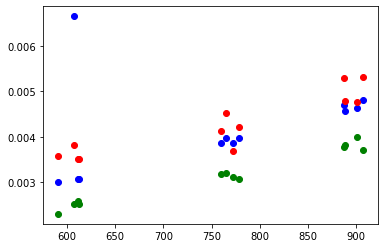

1.6467408430285353


In [28]:
m = []
cap = []
comp = []
rpms = 3000

for index, row in experimentalData.iterrows():
    m.append(row['Total Heat Load (W)'] / (row['h (j/kg)'][1] - row['h (j/kg)'][2]))
    cap.append(capillary_tube_func(row['P (Pa)'][2], row['h (j/kg)'][2], row['T (K)'][2]))
    comp.append(compr_func( [row['P (Pa)'][0], CP.PropsSI('H', 'P', row['P (Pa)'][0], 'Q', 1, 'R410a')], rpms, row['P (Pa)'][1] / row['P (Pa)'][0]))
    
print(m)
print (cap)
print(comp)

plt.plot(experimentalData['Total Heat Load (W)'], m, 'bo')
plt.plot(experimentalData['Total Heat Load (W)'], cap, 'ro')
plt.plot(experimentalData['Total Heat Load (W)'], comp, 'go')
plt.show()

print(comp[2] / comp[0])

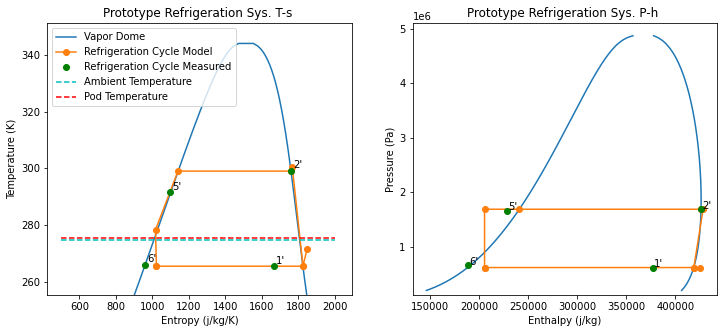

[-1.69211486 -0.02809251 -0.14899685]
[0.002291423558181951, 0.0061687754221363056]


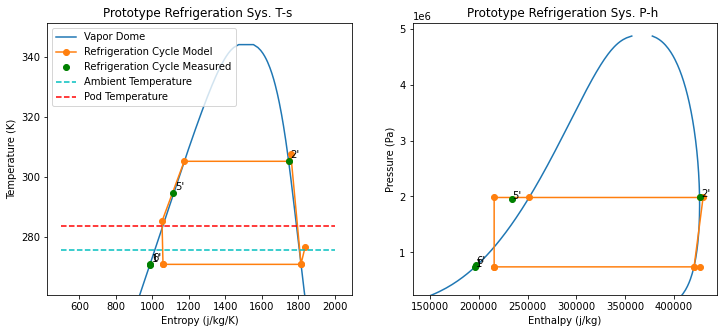

[-1.07182933 -0.02953075 -0.11695516]
[0.003199667628492739, 0.006629165235926513]


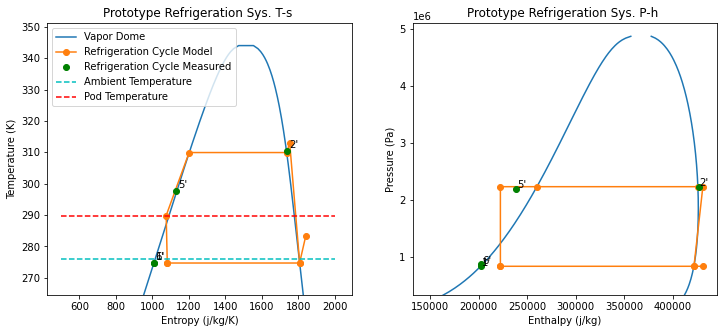

[-0.90625604 -0.04502258 -0.11140639]
[0.003773153023793471, 0.007192595732344524]


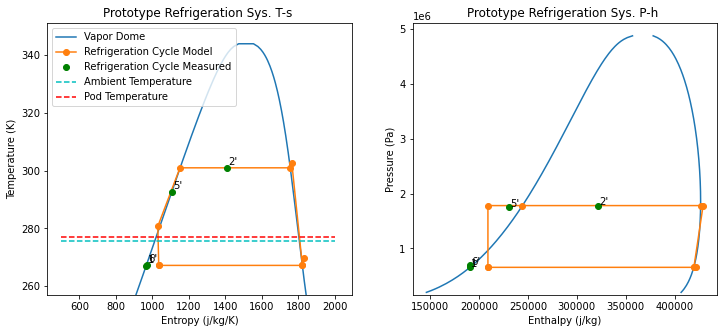

[-1.50283552 -0.01193619 -0.12237177]
[0.00250582710774663, 0.006271673096806796]


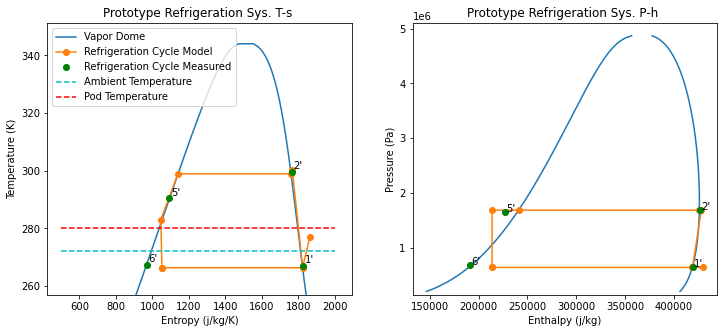

[-0.64731969 -0.05049884 -0.13053914]
[0.003100167680981846, 0.0051069672733438974]


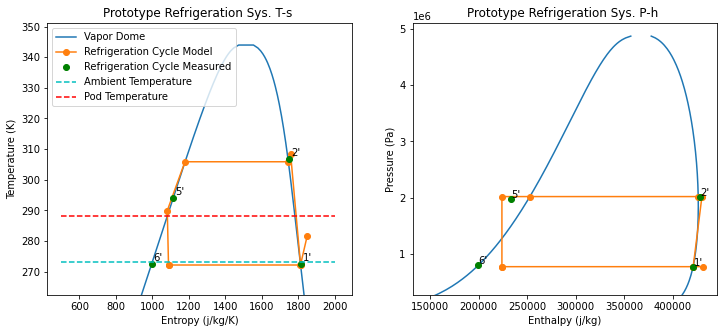

[-0.44463549 -0.04925855 -0.07948411]
[0.004001188490002975, 0.005780258888454751]


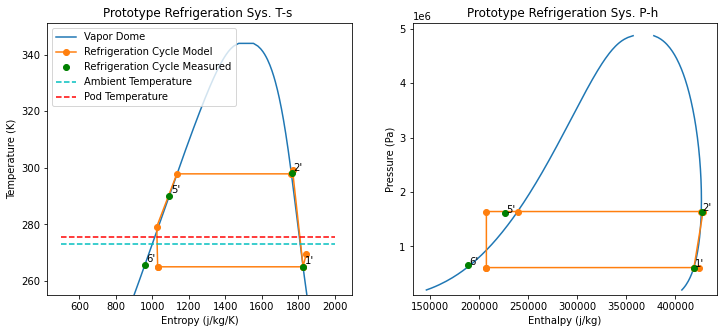

[-1.17240679 -0.02180544 -0.08826067]
[0.0025799031275563536, 0.005604599076821881]


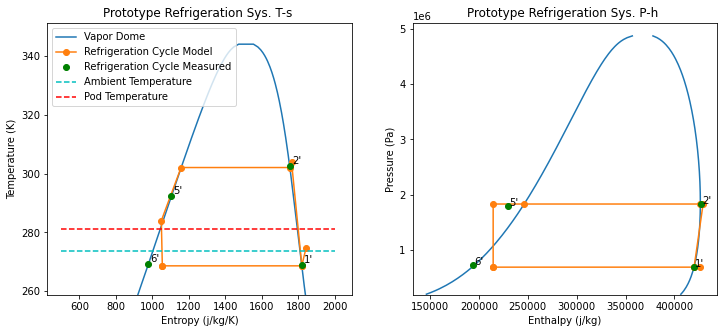

[-0.85305369 -0.02933463 -0.11764551]
[0.003167253470938965, 0.005869090740256685]


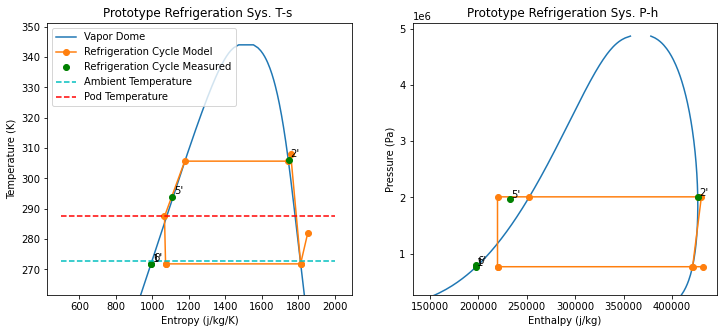

[-0.64158428 -0.05099318 -0.08726111]
[0.0038191522827822847, 0.0062694603491193785]


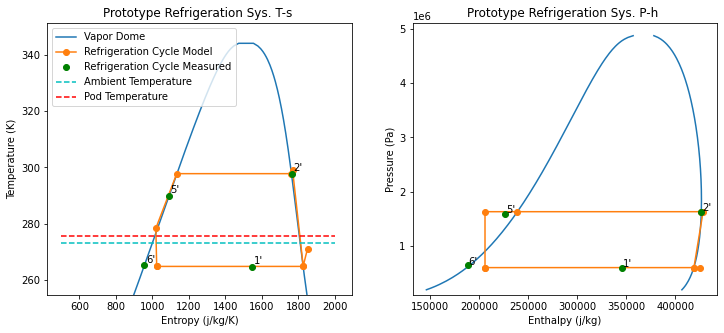

[-1.29448997 -0.02941373 -0.10355512]
[0.002507068938914451, 0.005752444533072569]


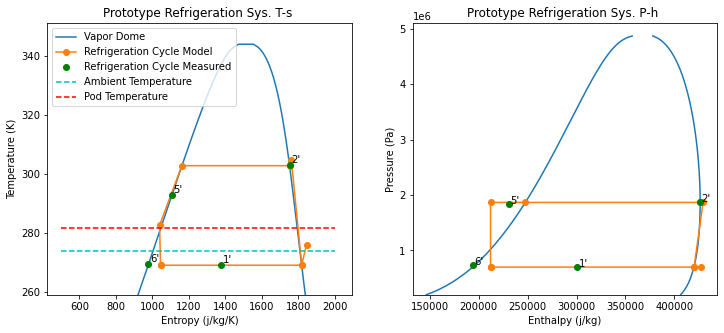

[-1.10360718 -0.03355715 -0.1536104 ]
[0.0030579360283762565, 0.006432696177002373]


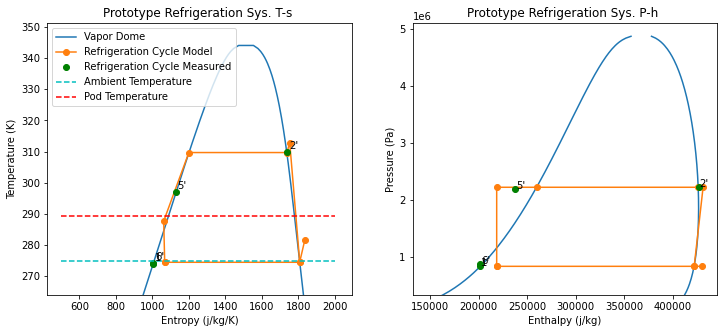

[-1.06267255 -0.03741593 -0.1346292 ]
[0.0037145251473117936, 0.007661849056440279]


In [29]:
from analysis_functions import *

makeData = pd.DataFrame()

for index, row in experimentalData.iterrows():
    
#     if index == 0:

    Inputs = np.array([
                       row['Ambient T (K)'],
                       row['Pod T (K)'],
                       row['Total Heat Load (W)'],
                      ])

    Param = np.array([rpms,
                      2900, # Matches HT-900 CFM of 350 CFM and ~ 40: W measured with power meter 01/22 https://www.cnet.com/products/honeywell-ht-900-turboforce-air-circulator-fan/
                      2900 # Matches 80 W measured with power meter 01/22
                     ])

    [P, T, h, s, abscissa, m_dot, Q_L, Q_H, W, W_fan_c, W_fan_e, COSP, Deficit] = make_cycle([row['P (Pa)'][1], row['P (Pa)'][0], 0.1],
                                                                                             Inputs,
                                                                                             Param)

    makeData = makeData.append(pd.DataFrame({'P (Pa)': [P], 'T (K)': [T], 'h (j/kg)': [h], 's (j/kg K)': [s], 'abcissa': [abscissa], 
                                               'Mass Flux (kg/s)': [m_dot], 'Evaporator Heat Transfer (W)': Q_L, 'Condenser Heat Transfer (W)': Q_H, 'Compressor Work (W)': W, 
                                               'Condenser Fan Work': W_fan_c, 'Evapoator Fan Work': W_fan_e, 'COSP': COSP, 'Deficits': [Deficit]}))


    thermodynamic_plots(experimentalData.iloc[index], makeData.iloc[-1], lgnd = ['Vapor Dome', 'Refrigeration Cycle Model',
                        'Refrigeration Cycle Measured', 'Ambient Temperature',
                       'Pod Temperature'], annotate = True)
    print(Deficit)
    print(m_dot)


makeData = makeData.reset_index()


[0.0027704433812335287, 0.003733707852939722, 0.004446395895309711, 0.0028897184145128896, 0.0037552568770401417, 0.004571884949199327, 0.0028927271100627782, 0.0036980278871801193, 0.004409111515497711, 0.002881433117755088, 0.003738366714917262, 0.004459255904660702]
[0.0061687754221363056, 0.006629165235926513, 0.007192595732344524, 0.006271673096806796, 0.0051069672733438974, 0.005780258888454751, 0.005604599076821881, 0.005869090740256685, 0.0062694603491193785, 0.005752444533072569, 0.006432696177002373, 0.007661849056440279]
[0.002292983258668772, 0.0032019497297514853, 0.0037759491844305314, 0.00250755650372138, 0.0031022932803905856, 0.00400407824160075, 0.0025816530094601325, 0.0031694679365926633, 0.0038219022546530272, 0.0025087669895953618, 0.003060081435701485, 0.0037172713554030883]


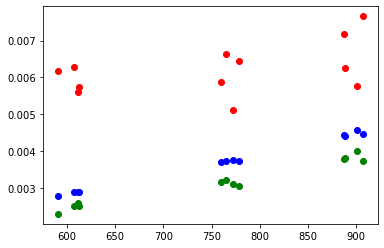

In [30]:
m = []
cap = []
comp = []

for index, row in makeData.iterrows():
    m.append(experimentalData['Total Heat Load (W)'][index] / (row['h (j/kg)'][0] - row['h (j/kg)'][4]))
    cap.append(capillary_tube_func(row['P (Pa)'][4], row['h (j/kg)'][4], row['T (K)'][4]))
    comp.append(compr_func( [row['P (Pa)'][0], CP.PropsSI('H', 'P', row['P (Pa)'][0], 'Q', 1, 'R410a')], rpms, row['P (Pa)'][1] / row['P (Pa)'][0]))
    
print(m)
print (cap)
print(comp)

plt.plot(experimentalData['Total Heat Load (W)'], m, 'bo')
plt.plot(experimentalData['Total Heat Load (W)'], cap, 'ro')
plt.plot(experimentalData['Total Heat Load (W)'], comp, 'go')
plt.show()

C:\ProgramData\Anaconda3\envs\jupyterlab-debugger\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
<ipython-input-16-9acb6d9ad708>:248: UserWarning: Flooded Compressor, vapor quality < 1
  warnings.warn('Flooded Compressor, vapor quality < 1')
<ipython-input-10-8bbdacef4da1>:104: UserWarning: Partial Evaporation
  warnings.warn('Partial Evaporation')


no exception when superheated phase takes up entire domain
initial Point: [2.68005012e+05 2.66451286e+05 5.00000000e-01]
Compression ratio too high: 3.192567722258793
initial Point: [2.68005012e+05 7.98061578e+05 5.00000000e-01]
Compression ratio too high: 3.1942407899443657
initial Point: [6.57270402e+05 4.43654717e+05 5.00000000e-01]
Compression ratio too high: 3.160484263715092
initial Point: [6.57270402e+05 6.20858147e+05 5.00000000e-01]
Compression ratio too high: 5.062700198806677
initial Point: [1.34896298e+06 2.66451286e+05 5.00000000e-01]
Compression ratio too high: 3.0405694547662403
initial Point: [1.34896298e+06 4.43654717e+05 5.00000000e-01]
Compression ratio too high: 3.196006580193935
initial Point: [1.34896298e+06 7.98061578e+05 5.00000000e-01]
Compression ratio too high: 8.793662731690771
initial Point: [2.34308275e+06 2.66451286e+05 5.00000000e-01]
Compression ratio too high: 5.281320490555126
initial Point: [2.34308275e+06 4.43654717e+05 5.00000000e-01]
Compression r

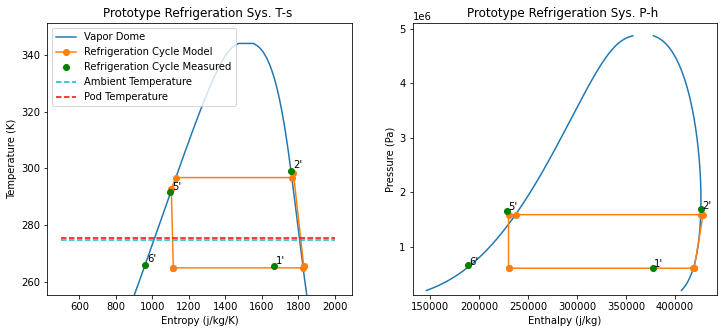

<ipython-input-16-9acb6d9ad708>:248: UserWarning: Flooded Compressor, vapor quality < 1
  warnings.warn('Flooded Compressor, vapor quality < 1')
<ipython-input-10-8bbdacef4da1>:104: UserWarning: Partial Evaporation
  warnings.warn('Partial Evaporation')


Gnielinski Not Valid for Re or Pr Re: 9021696.426140565 Pr: 1.0155944974338147
initial Point: [2.96523633e+05 2.89859394e+05 5.00000000e-01]
no exception when superheated phase takes up entire domain
initial Point: [2.96523633e+05 5.29484446e+05 5.00000000e-01]


C:\ProgramData\Anaconda3\envs\jupyterlab-debugger\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Compression ratio too high: 3.1913363680978364
initial Point: [2.96523633e+05 1.00873455e+06 5.00000000e-01]
Two-phase inputs not supported for pseudo-pure for now : PropsSI("H","P",289856.8439,"T",244.8661549,"R410a")
initial Point: [8.35080048e+05 2.89859394e+05 5.00000000e-01]
no exception when superheated phase takes up entire domain
initial Point: [8.35080048e+05 5.29484446e+05 5.00000000e-01]
no exception when superheated phase takes up entire domain
initial Point: [8.35080048e+05 7.69109497e+05 5.00000000e-01]
no exception when superheated phase takes up entire domain
initial Point: [8.35080048e+05 1.00873455e+06 5.00000000e-01]
Compression ratio too high: 6.149866404846795
initial Point: [1.78259655e+06 2.89859394e+05 5.00000000e-01]
Compression ratio too high: 3.366664621667743
initial Point: [1.78259655e+06 5.29484446e+05 5.00000000e-01]
Compression ratio too high: 10.829640865655646
initial Point: [3.13907314e+06 2.89859394e+05 5.00000000e-01]
Compression ratio too high: 5.9

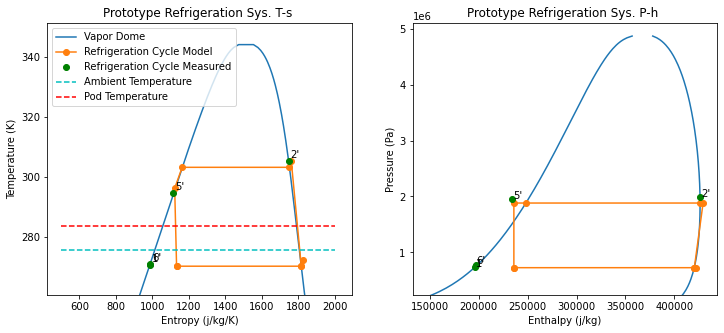

C:\ProgramData\Anaconda3\envs\jupyterlab-debugger\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
<ipython-input-16-9acb6d9ad708>:248: UserWarning: Flooded Compressor, vapor quality < 1
  warnings.warn('Flooded Compressor, vapor quality < 1')
<ipython-input-10-8bbdacef4da1>:104: UserWarning: Partial Evaporation
  warnings.warn('Partial Evaporation')


Gnielinski Not Valid for Re or Pr Re: 5734346.523423772 Pr: 1.0660917978974527
initial Point: [3.24171911e+05 3.11808628e+05 5.00000000e-01]
Compression ratio too high: 3.192699020182443
initial Point: [3.24171911e+05 9.08121310e+05 5.00000000e-01]
Compression ratio too high: 3.223559867517153
initial Point: [1.00513378e+06 3.11808628e+05 5.00000000e-01]
no exception when superheated phase takes up entire domain
initial Point: [1.00513378e+06 9.08121310e+05 5.00000000e-01]
no exception when superheated phase takes up entire domain
initial Point: [1.00513378e+06 1.20627765e+06 5.00000000e-01]
Compression ratio too high: 7.0394111650889375
initial Point: [2.19494914e+06 3.11808628e+05 5.00000000e-01]
Compression ratio too high: 3.598483926537493
initial Point: [2.19494914e+06 6.09964969e+05 5.00000000e-01]
Compression ratio too high: 12.487204119299369
initial Point: [3.89361798e+06 3.11808628e+05 5.00000000e-01]
Compression ratio too high: 6.383346881844459
initial Point: [3.89361798e+0

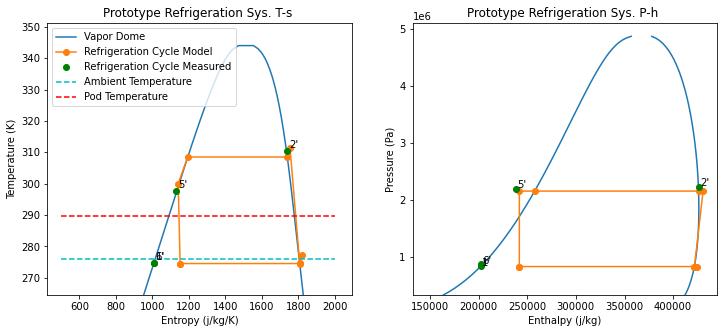

<ipython-input-10-8bbdacef4da1>:104: UserWarning: Partial Evaporation
  warnings.warn('Partial Evaporation')
C:\ProgramData\Anaconda3\envs\jupyterlab-debugger\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Compression ratio too high: 3.0205127287208575
initial Point: [2.70431223e+05 4.58329918e+05 5.00000000e-01]
Compression ratio too high: 3.1947077683555367
initial Point: [2.70431223e+05 8.34082527e+05 5.00000000e-01]
Compression ratio too high: 3.0076927365122033
initial Point: [6.78689347e+05 2.70453614e+05 5.00000000e-01]
Compression ratio too high: 5.204551254532498
initial Point: [1.40758970e+06 2.70453614e+05 5.00000000e-01]
Compression ratio too high: 3.0711276754980865
initial Point: [1.40758970e+06 4.58329918e+05 5.00000000e-01]
Compression ratio too high: 3.1960841759660714
initial Point: [1.40758970e+06 8.34082527e+05 5.00000000e-01]
Compression ratio too high: 9.085226242509977
initial Point: [2.45713227e+06 2.70453614e+05 5.00000000e-01]
Compression ratio too high: 5.361055811917484
initial Point: [2.45713227e+06 4.58329918e+05 5.00000000e-01]
Compression ratio too high: 3.802396490091406
initial Point: [2.45713227e+06 6.46206222e+05 5.00000000e-01]
[ 0.00013053 -0.0008662

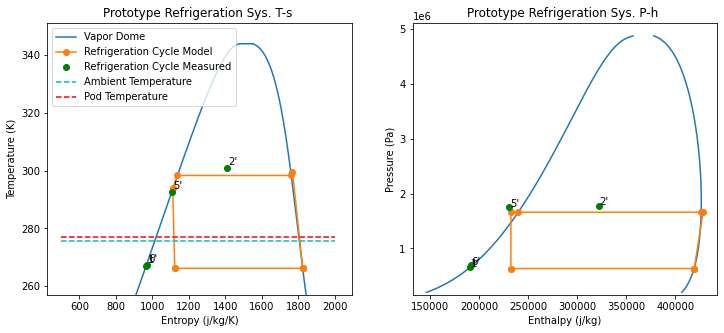

<ipython-input-16-9acb6d9ad708>:248: UserWarning: Flooded Compressor, vapor quality < 1
  warnings.warn('Flooded Compressor, vapor quality < 1')
<ipython-input-10-8bbdacef4da1>:104: UserWarning: Partial Evaporation
  warnings.warn('Partial Evaporation')


Gnielinski Not Valid for Re or Pr Re: 10519790.823747795 Pr: 1.0138378671443438
initial Point: [2.91453774e+05 2.79546055e+05 5.00000000e-01]


C:\ProgramData\Anaconda3\envs\jupyterlab-debugger\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


no exception when superheated phase takes up entire domain
initial Point: [7.84221274e+05 2.79546055e+05 5.00000000e-01]
no exception when superheated phase takes up entire domain
initial Point: [7.84221274e+05 4.91668869e+05 5.00000000e-01]
no exception when superheated phase takes up entire domain
initial Point: [7.84221274e+05 7.03791683e+05 5.00000000e-01]
no exception when superheated phase takes up entire domain
initial Point: [7.84221274e+05 9.15914498e+05 5.00000000e-01]
Compression ratio too high: 5.86311872100675
initial Point: [1.63901171e+06 2.79546055e+05 5.00000000e-01]
Compression ratio too high: 3.3335682046270256
initial Point: [1.63901171e+06 4.91668869e+05 5.00000000e-01]
Compression ratio too high: 3.018732776717275
initial Point: [1.63901171e+06 9.15914498e+05 5.00000000e-01]
Compression ratio too high: 10.215937689363756
initial Point: [2.85582508e+06 2.79546055e+05 5.00000000e-01]
Compression ratio too high: 5.808431771933532
initial Point: [2.85582508e+06 4.9166

<ipython-input-1-131377caf603>:227: UserWarning: Warning: |Deficit| = [0.07122665]
  warnings.warn('Warning: |Deficit| = ' +


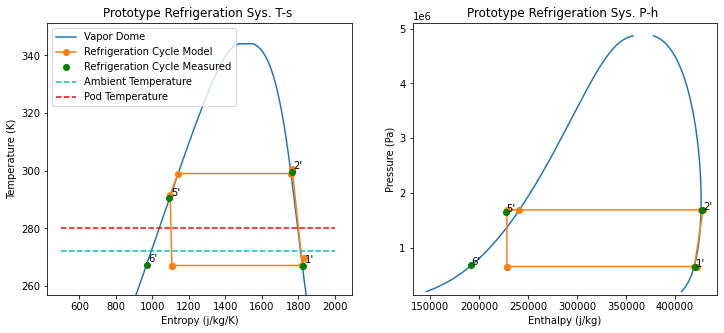

Compression ratio too high: 3.4592301623652286
initial Point: [3.24258047e+05 3.05767636e+05 5.00000000e-01]


<ipython-input-10-8bbdacef4da1>:104: UserWarning: Partial Evaporation
  warnings.warn('Partial Evaporation')
C:\ProgramData\Anaconda3\envs\jupyterlab-debugger\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


no exception when superheated phase takes up entire domain
initial Point: [3.24258047e+05 5.87814666e+05 5.00000000e-01]
no exception when superheated phase takes up entire domain
initial Point: [3.24258047e+05 1.15190873e+06 5.00000000e-01]
Compression ratio too high: 3.2264631872619693
initial Point: [9.86548022e+05 3.05767636e+05 5.00000000e-01]
Compression ratio too high: 6.9667224670346934
initial Point: [2.13019826e+06 3.05767636e+05 5.00000000e-01]
Compression ratio too high: 3.623928398118883
initial Point: [2.13019826e+06 5.87814666e+05 5.00000000e-01]
Compression ratio too high: 12.28124993982995
initial Point: [3.75520876e+06 3.05767636e+05 5.00000000e-01]
Compression ratio too high: 6.3884230543045035
initial Point: [3.75520876e+06 5.87814666e+05 5.00000000e-01]
Compression ratio too high: 4.31701819053751
initial Point: [3.75520876e+06 8.69861696e+05 5.00000000e-01]
Compression ratio too high: 3.2599881228516336
initial Point: [3.75520876e+06 1.15190873e+06 5.00000000e-01]

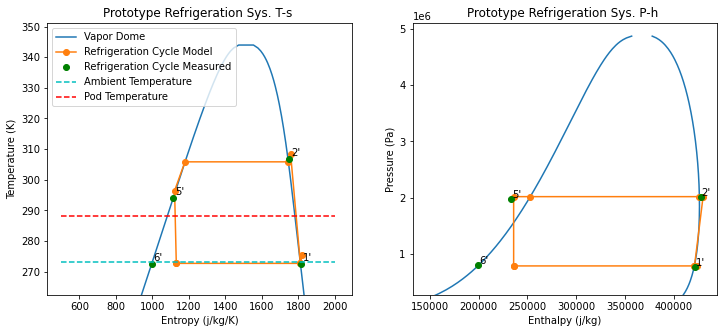

Compression ratio too high: 3.1608286481044203
initial Point: [2.72516461e+05 2.66884554e+05 5.00000000e-01]


<ipython-input-10-8bbdacef4da1>:104: UserWarning: Partial Evaporation
  warnings.warn('Partial Evaporation')
C:\ProgramData\Anaconda3\envs\jupyterlab-debugger\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Compression ratio too high: 3.196113803366467
initial Point: [2.72516461e+05 8.01960987e+05 5.00000000e-01]
Compression ratio too high: 3.1940447305936166
initial Point: [6.75168029e+05 4.45243365e+05 5.00000000e-01]
Compression ratio too high: 3.195001122232938
initial Point: [6.75168029e+05 8.01960987e+05 5.00000000e-01]
Compression ratio too high: 5.179088158337103
initial Point: [1.38221863e+06 2.66884554e+05 5.00000000e-01]
Compression ratio too high: 3.1044115244671184
initial Point: [1.38221863e+06 4.45243365e+05 5.00000000e-01]
Compression ratio too high: 8.968927723729413
initial Point: [2.39366828e+06 2.66884554e+05 5.00000000e-01]
Compression ratio too high: 5.376089716263514
initial Point: [2.39366828e+06 4.45243365e+05 5.00000000e-01]
Compression ratio too high: 3.838454014606454
initial Point: [2.39366828e+06 6.23602176e+05 5.00000000e-01]
[-1.15816610e-07  4.99749110e-08  1.72406596e-07]
[0.0031620460902028265, 0.0031620464564202843]


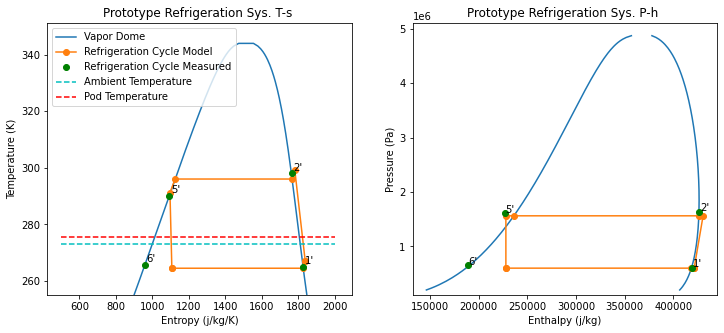

<ipython-input-16-9acb6d9ad708>:248: UserWarning: Flooded Compressor, vapor quality < 1
  warnings.warn('Flooded Compressor, vapor quality < 1')
<ipython-input-10-8bbdacef4da1>:104: UserWarning: Partial Evaporation
  warnings.warn('Partial Evaporation')


Gnielinski Not Valid for Re or Pr Re: 10188974.647384811 Pr: 1.01413755795727
initial Point: [2.91720180e+05 2.82734163e+05 5.00000000e-01]


C:\ProgramData\Anaconda3\envs\jupyterlab-debugger\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Compression ratio too high: 3.1921231671738557
initial Point: [2.91720180e+05 9.44607463e+05 5.00000000e-01]
Two-phase inputs not supported for pseudo-pure for now : PropsSI("H","P",282613.6855,"T",244.2957748,"R410a")
initial Point: [7.95173329e+05 2.82734163e+05 5.00000000e-01]
no exception when superheated phase takes up entire domain
initial Point: [7.95173329e+05 5.03358596e+05 5.00000000e-01]
no exception when superheated phase takes up entire domain
initial Point: [7.95173329e+05 7.23983029e+05 5.00000000e-01]
no exception when superheated phase takes up entire domain
initial Point: [7.95173329e+05 9.44607463e+05 5.00000000e-01]
Compression ratio too high: 5.924854743361716
initial Point: [1.67515884e+06 2.82734163e+05 5.00000000e-01]
Compression ratio too high: 3.3279631211868943
initial Point: [1.67515884e+06 5.03358596e+05 5.00000000e-01]
Compression ratio too high: 3.024694273937607
initial Point: [1.67515884e+06 7.23983029e+05 5.00000000e-01]
Compression ratio too high: 10.

<ipython-input-1-131377caf603>:227: UserWarning: Warning: |Deficit| = [0.05798812]
  warnings.warn('Warning: |Deficit| = ' +


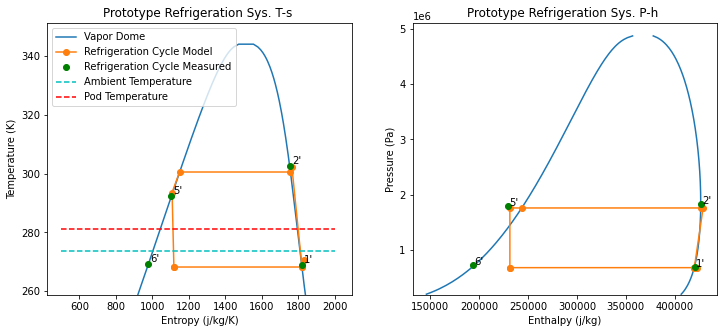

Compression ratio too high: 3.6279181199476565
initial Point: [3.22877942e+05 3.04060268e+05 5.00000000e-01]


<ipython-input-10-8bbdacef4da1>:104: UserWarning: Partial Evaporation
  warnings.warn('Partial Evaporation')
C:\ProgramData\Anaconda3\envs\jupyterlab-debugger\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Compression ratio too high: 3.0785669762891996
initial Point: [3.22877942e+05 5.81554316e+05 5.00000000e-01]
Compression ratio too high: 3.210368381386003
initial Point: [9.76145471e+05 3.04060268e+05 5.00000000e-01]
Two-phase inputs not supported for pseudo-pure for now : PropsSI("H","P",760166.3027,"T",271.5648299,"R410a")
initial Point: [9.76145471e+05 5.81554316e+05 5.00000000e-01]
Compression ratio too high: 3.018616437892581
initial Point: [9.76145471e+05 8.59048365e+05 5.00000000e-01]
Compression ratio too high: 3.195410931838092
initial Point: [9.76145471e+05 1.13654241e+06 5.00000000e-01]
Compression ratio too high: 6.916401327090071
initial Point: [2.10300284e+06 3.04060268e+05 5.00000000e-01]
Compression ratio too high: 3.6161761380933117
initial Point: [2.10300284e+06 5.81554316e+05 5.00000000e-01]
Compression ratio too high: 12.179986811018745
initial Point: [3.70345006e+06 3.04060268e+05 5.00000000e-01]
Compression ratio too high: 6.368192877382988
initial Point: [3.70345

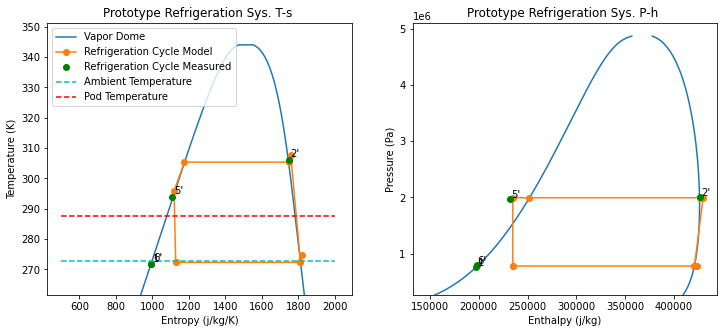

<ipython-input-16-9acb6d9ad708>:248: UserWarning: Flooded Compressor, vapor quality < 1
  warnings.warn('Flooded Compressor, vapor quality < 1')
<ipython-input-10-8bbdacef4da1>:104: UserWarning: Partial Evaporation
  warnings.warn('Partial Evaporation')


Gnielinski Not Valid for Re or Pr Re: 8551860.598521786 Pr: 1.0246255012625658
initial Point: [2.73162190e+05 2.67119339e+05 5.00000000e-01]


C:\ProgramData\Anaconda3\envs\jupyterlab-debugger\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Compression ratio too high: 3.0333150664638673
initial Point: [2.73162190e+05 8.04074055e+05 5.00000000e-01]
Compression ratio too high: 3.1941562978690112
initial Point: [6.78270320e+05 4.46104245e+05 5.00000000e-01]
Compression ratio too high: 3.1957616231015535
initial Point: [6.7827032e+05 6.2508915e+05 5.0000000e-01]
Compression ratio too high: 3.1940793604437943
initial Point: [6.78270320e+05 8.04074055e+05 5.00000000e-01]
Compression ratio too high: 5.199346569286365
initial Point: [1.38884602e+06 2.67119339e+05 5.00000000e-01]
Compression ratio too high: 3.1132768577764383
initial Point: [1.38884602e+06 4.46104245e+05 5.00000000e-01]
Compression ratio too high: 9.003051965349469
initial Point: [2.40488929e+06 2.67119339e+05 5.00000000e-01]
Compression ratio too high: 5.390868440787223
initial Point: [2.40488929e+06 4.46104245e+05 5.00000000e-01]
Compression ratio too high: 3.847274095642704
initial Point: [2.40488929e+06 6.25089150e+05 5.00000000e-01]
[-0.00159268  0.0089957   

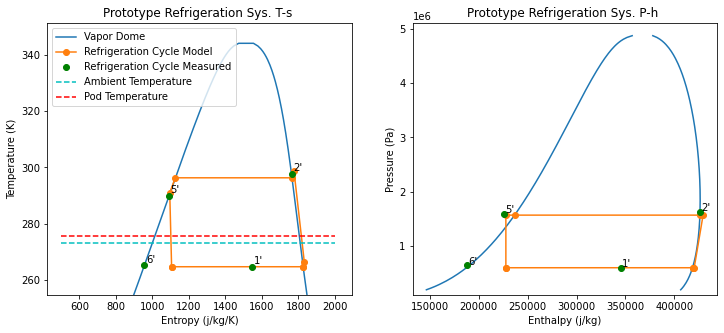

C:\ProgramData\Anaconda3\envs\jupyterlab-debugger\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
<ipython-input-16-9acb6d9ad708>:248: UserWarning: Flooded Compressor, vapor quality < 1
  warnings.warn('Flooded Compressor, vapor quality < 1')
<ipython-input-10-8bbdacef4da1>:104: UserWarning: Partial Evaporation
  warnings.warn('Partial Evaporation')


Gnielinski Not Valid for Re or Pr Re: 8771024.689817773 Pr: 1.0319271468205529
initial Point: [2.92740591e+05 2.83829847e+05 5.00000000e-01]
no exception when superheated phase takes up entire domain
initial Point: [2.92740591e+05 7.30922365e+05 5.00000000e-01]
Two-phase inputs not supported for pseudo-pure for now : PropsSI("H","P",283785.7704,"T",244.3956247,"R410a")
initial Point: [8.02343112e+05 2.83829847e+05 5.00000000e-01]
no exception when superheated phase takes up entire domain
initial Point: [8.02343112e+05 5.07376106e+05 5.00000000e-01]
no exception when superheated phase takes up entire domain
initial Point: [8.02343112e+05 7.30922365e+05 5.00000000e-01]
no exception when superheated phase takes up entire domain
initial Point: [8.02343112e+05 9.54468624e+05 5.00000000e-01]
Compression ratio too high: 5.96647815196065
initial Point: [1.69346458e+06 2.83829847e+05 5.00000000e-01]
Compression ratio too high: 3.3376908406386225
initial Point: [1.69346458e+06 5.07376106e+05 5.0

<ipython-input-1-131377caf603>:227: UserWarning: Warning: |Deficit| = [0.0741851]
  warnings.warn('Warning: |Deficit| = ' +


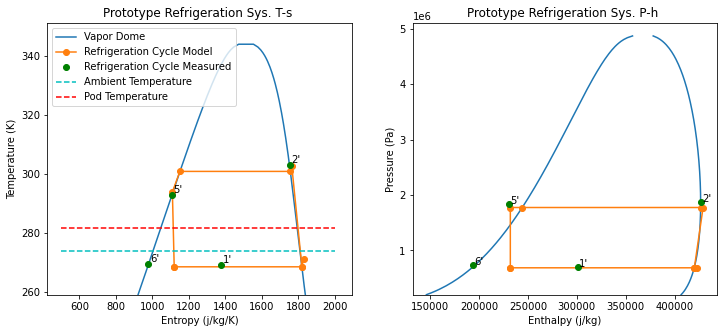

C:\ProgramData\Anaconda3\envs\jupyterlab-debugger\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
<ipython-input-10-8bbdacef4da1>:104: UserWarning: Partial Evaporation
  warnings.warn('Partial Evaporation')


no exception when superheated phase takes up entire domain
initial Point: [3.24684298e+05 6.02150769e+05 5.00000000e-01]
no exception when superheated phase takes up entire domain
initial Point: [3.24684298e+05 8.94624056e+05 5.00000000e-01]
Compression ratio too high: 3.230278184608611
initial Point: [1.00034442e+06 3.09677482e+05 5.00000000e-01]
Compression ratio too high: 3.1944357417586553
initial Point: [1.00034442e+06 6.02150769e+05 5.00000000e-01]
no exception when superheated phase takes up entire domain
initial Point: [1.00034442e+06 8.94624056e+05 5.00000000e-01]
no exception when superheated phase takes up entire domain
initial Point: [1.00034442e+06 1.18709734e+06 5.00000000e-01]
Compression ratio too high: 7.023949321021033
initial Point: [2.17515894e+06 3.09677482e+05 5.00000000e-01]
Compression ratio too high: 3.612316141772535
initial Point: [2.17515894e+06 6.02150769e+05 5.00000000e-01]


<ipython-input-16-9acb6d9ad708>:248: UserWarning: Flooded Compressor, vapor quality < 1
  warnings.warn('Flooded Compressor, vapor quality < 1')


For now, we don't support T [-1137.27 K] below Tmin(saturation) [200 K] : PropsSI("H","P",441662.0985,"T",-1137.274779,"R410a")
initial Point: [2.17515894e+06 1.18709734e+06 5.00000000e-01]
Compression ratio too high: 12.429472908160642
initial Point: [3.84912788e+06 3.09677482e+05 5.00000000e-01]
Compression ratio too high: 6.392299199184192
initial Point: [3.84912788e+06 6.02150769e+05 5.00000000e-01]
Compression ratio too high: 4.30250880760259
initial Point: [3.84912788e+06 8.94624056e+05 5.00000000e-01]
Compression ratio too high: 3.2424703029855517
initial Point: [3.84912788e+06 1.18709734e+06 5.00000000e-01]
[ 0.00454817 -0.01847035 -0.05682421]
[0.004603678904787563, 0.0045827406026925826]


<ipython-input-1-131377caf603>:227: UserWarning: Warning: |Deficit| = [0.05992354]
  warnings.warn('Warning: |Deficit| = ' +


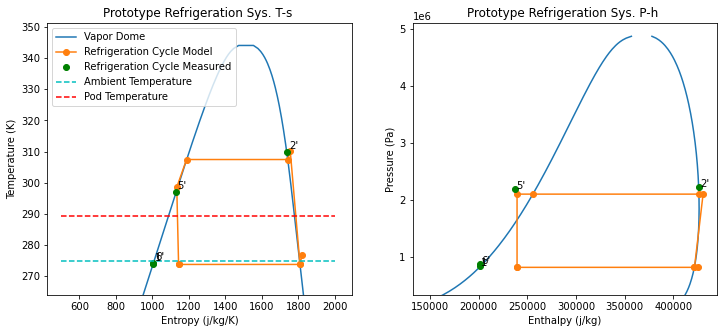

In [31]:
modelData = pd.DataFrame()
error_P = []
error_T = []

for index, row in experimentalData.iterrows():

    Inputs = np.array([
                       row['Ambient T (K)'],
                       row['Pod T (K)'],
                       row['Total Heat Load (W)'],
                      ])

    Param = np.array([rpms,
                      2900, # Matches HT-900 CFM of 350 CFM and ~ 40: W measured with power meter 01/22 https://www.cnet.com/products/honeywell-ht-900-turboforce-air-circulator-fan/
                      2900 # Matches 80 W measured with power meter 01/22
                     ])

    [Props, m_dot, Q_L, Q_H, W_comp, W_fan_c, W_fan_e, COSP, Deficit, converged] = solve_cycle_shotgun(Inputs, Param)

    modelData = modelData.append(pd.DataFrame({'P (Pa)': [Props[0]], 'T (K)': [Props[1]], 'h (j/kg)': [Props[2]], 's (j/kg K)': [Props[3]], 'abcissa': [Props[4]], 
                                               'Mass Flux (kg/s)': [m_dot], 'Evaporator Heat Transfer (W)': Q_L, 'Condenser Heat Transfer (W)': Q_H, 'Compressor Work (W)': W_comp, 
                                               'Condenser Fan Work': W_fan_c, 'Evapoator Fan Work': W_fan_e, 'COSP': COSP, 'Deficits': [Deficit]}))

    print(Deficit)
    print(m_dot)

    thermodynamic_plots(experimentalData.iloc[index], modelData.iloc[-1], lgnd = ['Vapor Dome', 'Refrigeration Cycle Model',
                        'Refrigeration Cycle Measured', 'Ambient Temperature',
                       'Pod Temperature'], annotate = True)
    



    one_P = (modelData.iloc[index]['P (Pa)'][0] - row['P (Pa)'][0]) / row['P (Pa)'][0]
    two_P = (modelData.iloc[index]['P (Pa)'][1] - row['P (Pa)'][1]) / row['P (Pa)'][1]
    five_P = (modelData.iloc[index]['P (Pa)'][4] - row['P (Pa)'][2]) / row['P (Pa)'][2]
    six_P = (modelData.iloc[index]['P (Pa)'][5] - row['P (Pa)'][3]) / row['P (Pa)'][3]
    error_P.append([one_P, two_P, five_P, six_P])
    
    one_T = (modelData.iloc[index]['T (K)'][0] - row['T (K)'][0]) 
    two_T = (modelData.iloc[index]['T (K)'][1] - row['T (K)'][1])
    five_T = (modelData.iloc[index]['T (K)'][4] - row['T (K)'][2])
    six_T = (modelData.iloc[index]['T (K)'][5] - row['T (K)'][3])
    error_T.append([one_T, two_T, five_T, six_T])

modelData = modelData.reset_index()

modelData['Pressure Error'] = error_P
modelData['Temperature Error'] = error_T
modelData['Heat Rejection Error'] = (modelData['Evaporator Heat Transfer (W)'] - experimentalData['Total Heat Load (W)']) / experimentalData['Total Heat Load (W)']
modelData['Work Error'] = (modelData['Compressor Work (W)'] - experimentalData['Compressor Work (W)']) / experimentalData['Compressor Work (W)']
modelData['COP Error'] = (modelData['Evaporator Heat Transfer (W)'] / modelData['Compressor Work (W)']  - experimentalData['COP']) / experimentalData['COP']
modelData['COSP Error'] = (modelData['COSP']  - experimentalData['COSP']) / experimentalData['COSP']

modelData.to_pickle(path + 'modelDataframe.pkl')

modelData = pd.read_pickle(path + 'modelDataframe.pkl')

In [ ]:
modelData

In [ ]:
error_P = []
error_T = []

for index, row in experimentalData.iterrows():
    one_P = (modelData.iloc[index]['P (Pa)'][0] - row['P (Pa)'][0]) / row['P (Pa)'][0]
    two_P = (modelData.iloc[index]['P (Pa)'][1] - row['P (Pa)'][1]) / row['P (Pa)'][1]
    five_P = (modelData.iloc[index]['P (Pa)'][4] - row['P (Pa)'][2]) / row['P (Pa)'][2]
    six_P = (modelData.iloc[index]['P (Pa)'][5] - row['P (Pa)'][3]) / row['P (Pa)'][3]
    error_P.append([one_P, two_P, five_P, six_P])
    
    one_T = (modelData.iloc[index]['T (K)'][0] - row['T (K)'][0]) 
    two_T = (modelData.iloc[index]['T (K)'][1] - row['T (K)'][1])
    five_T = (modelData.iloc[index]['T (K)'][4] - row['T (K)'][2])
    six_T = (modelData.iloc[index]['T (K)'][5] - row['T (K)'][3])
    error_T.append([one_T, two_T, five_T, six_T])
    
modelData['Pressure Error'] = error_P
modelData['Temperature Error'] = error_T
modelData['Heat Rejection Error'] = (modelData['Evaporator Heat Transfer (W)'] - experimentalData['Total Heat Load (W)']) / experimentalData['Total Heat Load (W)']
modelData['Work Error'] = (modelData['Compressor Work (W)'] - experimentalData['Compressor Work (W)']) / experimentalData['Compressor Work (W)']
modelData['COP Error'] = (modelData['Evaporator Heat Transfer (W)'] / modelData['Compressor Work (W)']  - experimentalData['COP']) / experimentalData['COP']
modelData['COSP Error'] = (modelData['COSP']  - experimentalData['COSP']) / experimentalData['COSP']


In [ ]:
for index, row in modelData.iterrows():
    print(max(row['Pressure Error']))